# 🌎 Análisis de Sentimiento Multilingüe para Comentarios Turísticos

## Pipeline End-to-End Profesional

**Objetivo Principal:** Enriquecer el dataset de comentarios turísticos con métricas de sentimiento multilingüe, análisis por aspectos (ABSA) y emociones.

### Estructura del Notebook:

| Fase | Descripción |
|------|-------------|
| **0** | Configuración y Contexto |
| **1** | Carga y Verificación del Dataset |
| **2** | Limpieza Básica y Tipificación |
| **3** | EDA General (No Textual) |
| **4** | EDA de Texto Multilingüe |
| **5** | Diseño del Esquema de Sentimiento |
| **6** | Generación de Sentimientos (Transformer Multilingüe) |
| **7** | Modelo Baseline (TF-IDF + Clasificador) |
| **8** | ABSA: Análisis de Sentimiento por Aspectos |
| **9** | Modelo de Emociones |
| **10** | Evaluación y Comparación de Modelos |
| **11** | Explicabilidad Avanzada |
| **12** | Integración y Exportación del Dataset Enriquecido |
| **13** | Documentación y Metadatos JSON |

---

**Archivo de entrada:** `p3-sentimiento_comentariosmuestra.xlsx`

**Columnas esperadas (15):**
- `ID`, `Fecha_publicacion`, `Titulo`, `Idioma_comentario`, `Comentario`
- `Rating_usuario`, `Fecha_viaje`, `Tipo_trip`, `Cantidad_contribuciones_usuario`
- `Lugar_numero_reviews`, `Lugar_rating`, `DEPARTAMENTO`, `AÑO`, `MES`, `DIA`

---
# 📦 FASE 0: Configuración y Contexto
---

In [1]:
# ============================================================================
# FASE 0.1: IMPORTACIÓN DE LIBRERÍAS
# ============================================================================

# --- Manipulación de datos ---
import pandas as pd
import numpy as np

# --- Visualización ---
import matplotlib.pyplot as plt
import seaborn as sns
try:
    import plotly.express as px
    import plotly.graph_objects as go
    PLOTLY_AVAILABLE = True
except ImportError:
    PLOTLY_AVAILABLE = False
    print("⚠️ Plotly no disponible, usando solo matplotlib")

# --- Texto y utilidades ---
import re
import string
from collections import Counter, defaultdict
try:
    from langdetect import detect, LangDetectException
    LANGDETECT_AVAILABLE = True
except ImportError:
    LANGDETECT_AVAILABLE = False
    print("⚠️ langdetect no disponible")

try:
    from tqdm.auto import tqdm
    tqdm.pandas()
except ImportError:
    tqdm = lambda x, **kwargs: x
    print("⚠️ tqdm no disponible")

# --- Modelado de sentimiento ---
try:
    from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
    import torch
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    TRANSFORMERS_AVAILABLE = False
    print("⚠️ transformers/torch no disponible")

# --- Machine Learning clásico ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, f1_score)

# --- Otros ---
import json
import os
import warnings
from datetime import datetime, timedelta
import time
from typing import Dict, List, Tuple, Optional, Any

warnings.filterwarnings('ignore')
print("✓ Librerías importadas correctamente")

c:\Users\PC\Documents\Proyectos\02_Academico\Tesis\Versiones\Tesis_v4\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Librerías importadas correctamente


In [2]:
# ============================================================================
# FASE 0.2: CONFIGURACIÓN GLOBAL
# ============================================================================

# --- Rutas de archivos ---
DATA_PATH = "./p3-sentimiento_comentarios_transformed.xlsx"

# Rutas de salida
OUTPUT_XLSX = "./p3-sentimiento_comentarios_with_sentiment.xlsx"
OUTPUT_PARQUET = "./p3-sentimiento_comentarios_with_sentiment.parquet"
OUTPUT_CSV = "./p3-sentimiento_comentarios_with_sentiment.csv"
METADATA_JSON = "./sentiment_model_metadata.json"

# Carpetas de salida
FIGURES_DIR = "./figures"
REPORTS_DIR = "./reports"
MODELS_DIR = "./models"

# Crear carpetas
for directory in [FIGURES_DIR, REPORTS_DIR, MODELS_DIR]:
    os.makedirs(directory, exist_ok=True)
    os.makedirs(f"{directory}/eda_general", exist_ok=True)
    os.makedirs(f"{directory}/eda_text", exist_ok=True)

# --- Semilla para reproducibilidad ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
if TRANSFORMERS_AVAILABLE:
    torch.manual_seed(RANDOM_STATE)

# --- Configuración de Pandas ---
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# --- Configuración de Matplotlib/Seaborn ---
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
sns.set_style('whitegrid')
sns.set_palette('husl')

# --- Columnas esperadas del dataset ---
EXPECTED_COLUMNS = [
    'ID', 'Fecha_publicacion', 'Titulo', 'Idioma_comentario', 'Comentario',
    'Rating_usuario', 'Fecha_viaje', 'Tipo_trip', 'Cantidad_contribuciones_usuario',
    'Lugar_numero_reviews', 'Lugar_rating', 'DEPARTAMENTO', 'AÑO', 'MES', 'DIA'
]

# --- Configuración de modelos ---
MODEL_CONFIG = {
    'sentiment_multilingual': 'clapAI/roberta-large-multilingual-sentiment',
    'sentiment_alternative': 'nlptown/bert-base-multilingual-uncased-sentiment',
    'batch_size_gpu': 64,
    'batch_size_cpu': 16,
    'max_length': 256
}

# --- Verificar dispositivo ---
if TRANSFORMERS_AVAILABLE:
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    DEVICE_ID = 0 if torch.cuda.is_available() else -1
else:
    DEVICE = 'cpu'
    DEVICE_ID = -1

print("="*60)
print("CONFIGURACIÓN GLOBAL ESTABLECIDA")
print("="*60)
print(f"📁 Archivo de entrada: {DATA_PATH}")
print(f"📁 Salida XLSX: {OUTPUT_XLSX}")
print(f"🎲 Semilla aleatoria: {RANDOM_STATE}")
print(f"🖥️  Dispositivo: {DEVICE}")
if TRANSFORMERS_AVAILABLE and torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
print(f"🧠 Modelo principal: {MODEL_CONFIG['sentiment_multilingual']}")
print("="*60)

CONFIGURACIÓN GLOBAL ESTABLECIDA
📁 Archivo de entrada: ./p3-sentimiento_comentarios_transformed.xlsx
📁 Salida XLSX: ./p3-sentimiento_comentarios_with_sentiment.xlsx
🎲 Semilla aleatoria: 42
🖥️  Dispositivo: cuda
🎮 GPU: NVIDIA GeForce RTX 4070 Ti SUPER
🧠 Modelo principal: clapAI/roberta-large-multilingual-sentiment


---
# 📥 FASE 1: Carga y Verificación del Dataset
---

In [3]:
# ============================================================================
# FASE 1.1: CARGA DEL DATASET
# ============================================================================

print("⏳ Cargando dataset...")
t_start = time.time()

df_raw = pd.read_excel(DATA_PATH)

t_elapsed = time.time() - t_start
print(f"✓ Dataset cargado en {t_elapsed:.2f} segundos")
print(f"📊 Dimensiones: {df_raw.shape[0]:,} filas × {df_raw.shape[1]} columnas")

⏳ Cargando dataset...
✓ Dataset cargado en 32.21 segundos
📊 Dimensiones: 196,313 filas × 15 columnas


In [4]:
# ============================================================================
# FASE 1.2: VERIFICACIÓN DE ESTRUCTURA
# ============================================================================

print("="*60)
print("VERIFICACIÓN DE COLUMNAS")
print("="*60)

actual_columns = df_raw.columns.tolist()

print("\n📋 Columnas ESPERADAS (15):")
for i, col in enumerate(EXPECTED_COLUMNS, 1):
    status = "✓" if col in actual_columns else "✗"
    print(f"   {i:2d}. {status} {col}")

print("\n📋 Columnas REALES encontradas:")
for i, col in enumerate(actual_columns, 1):
    status = "✓" if col in EXPECTED_COLUMNS else "⚠️ (extra)"
    print(f"   {i:2d}. {status} {col}")

# Verificar coincidencia
missing = set(EXPECTED_COLUMNS) - set(actual_columns)
extra = set(actual_columns) - set(EXPECTED_COLUMNS)

print(f"\n📊 Resumen:")
print(f"   - Columnas esperadas: {len(EXPECTED_COLUMNS)}")
print(f"   - Columnas encontradas: {len(actual_columns)}")
print(f"   - Columnas faltantes: {len(missing)} {list(missing) if missing else ''}")
print(f"   - Columnas extra: {len(extra)} {list(extra) if extra else ''}")

VERIFICACIÓN DE COLUMNAS

📋 Columnas ESPERADAS (15):
    1. ✓ ID
    2. ✓ Fecha_publicacion
    3. ✓ Titulo
    4. ✓ Idioma_comentario
    5. ✓ Comentario
    6. ✓ Rating_usuario
    7. ✓ Fecha_viaje
    8. ✓ Tipo_trip
    9. ✓ Cantidad_contribuciones_usuario
   10. ✓ Lugar_numero_reviews
   11. ✓ Lugar_rating
   12. ✓ DEPARTAMENTO
   13. ✓ AÑO
   14. ✓ MES
   15. ✓ DIA

📋 Columnas REALES encontradas:
    1. ✓ ID
    2. ✓ Fecha_publicacion
    3. ✓ Titulo
    4. ✓ Idioma_comentario
    5. ✓ Comentario
    6. ✓ Rating_usuario
    7. ✓ Fecha_viaje
    8. ✓ Tipo_trip
    9. ✓ Cantidad_contribuciones_usuario
   10. ✓ Lugar_numero_reviews
   11. ✓ Lugar_rating
   12. ✓ DEPARTAMENTO
   13. ✓ AÑO
   14. ✓ MES
   15. ✓ DIA

📊 Resumen:
   - Columnas esperadas: 15
   - Columnas encontradas: 15
   - Columnas faltantes: 0 
   - Columnas extra: 0 


In [5]:
# ============================================================================
# FASE 1.3: INFORMACIÓN BÁSICA DEL DATASET
# ============================================================================

print("="*60)
print("INFORMACIÓN BÁSICA DEL DATASET")
print("="*60)

# Tipos de datos
print("\n📊 Tipos de datos por columna:")
dtype_df = pd.DataFrame({
    'Columna': df_raw.columns,
    'Tipo': df_raw.dtypes.values,
    'Nulos': df_raw.isna().sum().values,
    '% Nulos': (df_raw.isna().sum().values / len(df_raw) * 100).round(2),
    'No Nulos': df_raw.notna().sum().values
})
display(dtype_df)

# Verificar unicidad de ID
print("\n🔑 Verificación de ID:")
n_unique_ids = df_raw['ID'].nunique()
n_total_rows = len(df_raw)
n_duplicates = n_total_rows - n_unique_ids

print(f"   - Total de filas: {n_total_rows:,}")
print(f"   - IDs únicos: {n_unique_ids:,}")
print(f"   - IDs duplicados: {n_duplicates:,}")

# Vista previa
print("\n📋 Vista previa del dataset:")
display(df_raw.head())

INFORMACIÓN BÁSICA DEL DATASET

📊 Tipos de datos por columna:


,Columna,Tipo,Nulos,% Nulos,No Nulos
0,ID,int64,0,0.0000,196313
1,Fecha_publicacion,datetime64[ns],288,0.1500,196025
2,Titulo,object,293,0.1500,196020
3,Idioma_comentario,object,288,0.1500,196025
4,Comentario,object,288,0.1500,196025
5,Rating_usuario,int64,0,0.0000,196313
6,Fecha_viaje,object,6277,3.2000,190036
7,Tipo_trip,object,6277,3.2000,190036
8,Cantidad_contribuciones_usuario,int64,0,0.0000,196313
9,Lugar_numero_reviews,int64,0,0.0000,196313



🔑 Verificación de ID:
   - Total de filas: 196,313
   - IDs únicos: 69,994
   - IDs duplicados: 126,319

📋 Vista previa del dataset:


,ID,Fecha_publicacion,Titulo,Idioma_comentario,Comentario,Rating_usuario,Fecha_viaje,Tipo_trip,Cantidad_contribuciones_usuario,Lugar_numero_reviews,Lugar_rating,DEPARTAMENTO,AÑO,MES,DIA
0,0,2025-01-10,Maravillosa Experiencia,es,Me encanto la historia y los paisajes de esta hermosa ciudad; es un paseo muy ilustrativo y llen...,5,2025-01,FAMILY,1,6,4.8000,Amazonas,2025.0000,1.0000,10.0000
1,1,2022-06-19,Leymebamba beauty,en,I went independently to Leymebamba\nI do NOT normally do tours unless there is no option\nI went...,4,2022-06,SOLO,29,6,4.8000,Amazonas,2022.0000,6.0000,19.0000
2,2,2020-03-01,Cañón del Sonche Huancas,es,Vista espectacular y a la vez nos hace ver lo pequeño que somos frente a la creación de paisajes...,5,2020-03,FRIENDS,1,6,4.8000,Amazonas,2020.0000,3.0000,1.0000
3,3,2020-02-23,Impresionante vista,es,"Para ir a conocer los sarcofagos de Karajia, se tiene que relizar una caminata de mas o menos 20...",5,2019-09,NONE,17,6,4.8000,Amazonas,2020.0000,2.0000,23.0000
4,4,2020-01-21,SARCOFAGOS DE KARAJIA Y CAVERNAS DE QUIOCTA,es,Vale la pena el tiempo en el desplazamiento para poder ver lo que encontre tanto en el trayecto ...,5,2019-12,NONE,2,6,4.8000,Amazonas,2020.0000,1.0000,21.0000


---
# 🧹 FASE 2: Limpieza Básica y Tipificación de Columnas
---

In [6]:
# ============================================================================
# FASE 2.1: COPIA DE TRABAJO Y CONVERSIÓN DE FECHAS
# ============================================================================

print("⏳ Iniciando limpieza y tipificación...")

# Crear copia de trabajo
df = df_raw.copy()

# --- Conversión de fechas ---
print("\n📅 Conversión de columnas de fecha:")

# Fecha_publicacion
df['Fecha_publicacion'] = pd.to_datetime(df['Fecha_publicacion'], errors='coerce')
n_nat_pub = df['Fecha_publicacion'].isna().sum()
print(f"   - Fecha_publicacion: {n_nat_pub:,} valores NaT ({n_nat_pub/len(df)*100:.2f}%)")

# Fecha_viaje
df['Fecha_viaje'] = pd.to_datetime(df['Fecha_viaje'], errors='coerce', format='mixed')
n_nat_viaje = df['Fecha_viaje'].isna().sum()
print(f"   - Fecha_viaje: {n_nat_viaje:,} valores NaT ({n_nat_viaje/len(df)*100:.2f}%)")

⏳ Iniciando limpieza y tipificación...

📅 Conversión de columnas de fecha:
   - Fecha_publicacion: 288 valores NaT (0.15%)
   - Fecha_viaje: 6,277 valores NaT (3.20%)


In [7]:
# ============================================================================
# FASE 2.2: CONVERSIÓN DE VARIABLES NUMÉRICAS
# ============================================================================

print("\n🔢 Conversión de columnas numéricas:")

numeric_columns = ['Rating_usuario', 'Cantidad_contribuciones_usuario', 
                   'Lugar_numero_reviews', 'Lugar_rating', 'AÑO', 'MES', 'DIA']

for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        n_invalid = df[col].isna().sum() - df_raw[col].isna().sum()
        if n_invalid > 0:
            print(f"   - {col}: {n_invalid} valores no convertibles")

# Resumen estadístico
print("\n📊 Estadísticas de variables numéricas:")
display(df[numeric_columns].describe().T)


🔢 Conversión de columnas numéricas:

📊 Estadísticas de variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Rating_usuario,196313.0000,4.5055,0.7938,0.0000,4.0000,5.0000,5.0000,5.0000
Cantidad_contribuciones_usuario,196313.0000,326.9682,3306.2913,0.0000,7.0000,35.0000,131.0000,410129.0000
Lugar_numero_reviews,196313.0000,3632.5805,4598.2034,0.0000,473.0000,1418.0000,6448.0000,19318.0000
Lugar_rating,196313.0000,4.5068,0.3681,0.0000,4.4000,4.5000,4.7000,5.0000
AÑO,196025.0000,2017.6808,3.2607,2004.0000,2015.0000,2017.0000,2019.0000,2025.0000
MES,196025.0000,6.7312,3.3400,1.0000,4.0000,7.0000,10.0000,12.0000
DIA,196025.0000,15.6340,8.8758,1.0000,8.0000,15.0000,23.0000,31.0000


In [8]:
# ============================================================================
# FASE 2.3: LIMPIEZA DE COLUMNAS TEXTUALES
# ============================================================================

print("\n📝 Limpieza de columnas textuales:")

text_columns = ['Titulo', 'Comentario', 'Idioma_comentario', 'Tipo_trip', 'DEPARTAMENTO']

for col in text_columns:
    if col in df.columns:
        # Convertir a string y hacer strip
        df[col] = df[col].astype(str).str.strip()
        # Reemplazar cadenas vacías y 'nan' por NaN real
        df[col] = df[col].replace(['', 'nan', 'None', 'NaN', 'null'], np.nan)
        n_empty = df[col].isna().sum()
        n_unique = df[col].nunique()
        print(f"   - {col}: {n_empty:,} vacíos, {n_unique:,} valores únicos")

print("\n✓ Limpieza completada")


📝 Limpieza de columnas textuales:
   - Titulo: 293 vacíos, 139,551 valores únicos
   - Comentario: 288 vacíos, 195,926 valores únicos
   - Idioma_comentario: 288 vacíos, 24 valores únicos
   - Tipo_trip: 6,277 vacíos, 6 valores únicos
   - DEPARTAMENTO: 0 vacíos, 21 valores únicos

✓ Limpieza completada


In [9]:
# ============================================================================
# FASE 2.4: DICCIONARIO DE DATOS
# ============================================================================

print("\n📖 DICCIONARIO DE DATOS")
print("="*80)

def get_column_info(df, col):
    info = {
        'columna': col,
        'tipo': str(df[col].dtype),
        'n_nulos': df[col].isna().sum(),
        'pct_nulos': round(df[col].isna().sum() / len(df) * 100, 2),
        'n_unicos': df[col].nunique()
    }
    
    if df[col].dtype in ['int64', 'float64']:
        info['min'] = df[col].min()
        info['max'] = df[col].max()
        info['mean'] = round(df[col].mean(), 2) if df[col].notna().any() else None
        info['categoria'] = 'numérica'
    elif 'datetime' in str(df[col].dtype):
        info['categoria'] = 'fecha'
        info['min'] = str(df[col].min())
        info['max'] = str(df[col].max())
        info['mean'] = None
    else:
        info['categoria'] = 'texto/categórica'
        info['min'] = None
        info['max'] = None
        info['mean'] = None
    
    return info

data_dict = [get_column_info(df, col) for col in df.columns if not col.startswith('_')]
df_data_dict = pd.DataFrame(data_dict)
df_data_dict = df_data_dict.sort_values(['categoria', 'columna']).reset_index(drop=True)
display(df_data_dict)

# Guardar
df_data_dict.to_excel(f"{REPORTS_DIR}/data_dictionary.xlsx", index=False)
print(f"\n✓ Diccionario guardado en {REPORTS_DIR}/data_dictionary.xlsx")


📖 DICCIONARIO DE DATOS


,columna,tipo,n_nulos,pct_nulos,n_unicos,min,max,mean,categoria
0,Fecha_publicacion,datetime64[ns],288,0.1500,5200,2004-08-27 00:00:00,2025-07-02 00:00:00,NaN,fecha
1,Fecha_viaje,datetime64[ns],6277,3.2000,184,2009-06-01 00:00:00,2025-07-01 00:00:00,NaN,fecha
2,AÑO,float64,288,0.1500,22,2004.0000,2025.0000,2017.6800,numérica
3,Cantidad_contribuciones_usuario,int64,0,0.0000,2216,0,410129,326.9700,numérica
4,DIA,float64,288,0.1500,31,1.0000,31.0000,15.6300,numérica
5,ID,int64,0,0.0000,69994,0,69993,19497.8700,numérica
6,Lugar_numero_reviews,int64,0,0.0000,325,0,19318,3632.5800,numérica
7,Lugar_rating,float64,0,0.0000,32,0.0000,5.0000,4.5100,numérica
8,MES,float64,288,0.1500,12,1.0000,12.0000,6.7300,numérica
9,Rating_usuario,int64,0,0.0000,6,0,5,4.5100,numérica



✓ Diccionario guardado en ./reports/data_dictionary.xlsx


---
# 📊 FASE 3: EDA General (No Textual)
---

In [10]:
# ============================================================================
# FASE 3.1: DISTRIBUCIÓN DE RATING_USUARIO
# ============================================================================

print("="*60)
print("ANÁLISIS DE RATING_USUARIO")
print("="*60)

# Estadísticas
rating_stats = df['Rating_usuario'].describe()
print("\n📊 Estadísticas de Rating:")
print(f"   Media: {rating_stats['mean']:.3f}")
print(f"   Mediana: {rating_stats['50%']:.1f}")
print(f"   Desv. Estándar: {rating_stats['std']:.3f}")

# Conteo por rating
rating_counts = df['Rating_usuario'].value_counts().sort_index()
rating_pcts = (rating_counts / rating_counts.sum() * 100).round(2)

print("\n📋 Distribución de ratings:")
for rating in sorted(rating_counts.index):
    count = rating_counts[rating]
    pct = rating_pcts[rating]
    bar = "█" * int(pct / 2)
    print(f"   ⭐{int(rating)}: {count:>6,} ({pct:>5.1f}%) {bar}")

# Categorización
n_neg = df[df['Rating_usuario'].isin([1, 2])].shape[0]
n_neu = df[df['Rating_usuario'] == 3].shape[0]
n_pos = df[df['Rating_usuario'].isin([4, 5])].shape[0]
n_total = n_neg + n_neu + n_pos

print("\n📊 Categorización por polaridad potencial:")
print(f"   🔴 Negativos (1-2): {n_neg:,} ({n_neg/n_total*100:.1f}%)")
print(f"   🟡 Neutrales (3):   {n_neu:,} ({n_neu/n_total*100:.1f}%)")
print(f"   🟢 Positivos (4-5): {n_pos:,} ({n_pos/n_total*100:.1f}%)")

ANÁLISIS DE RATING_USUARIO

📊 Estadísticas de Rating:
   Media: 4.505
   Mediana: 5.0
   Desv. Estándar: 0.794

📋 Distribución de ratings:
   ⭐0:    288 (  0.1%) 
   ⭐1:  1,951 (  1.0%) 
   ⭐2:  2,592 (  1.3%) 
   ⭐3: 14,957 (  7.6%) ███
   ⭐4: 50,143 ( 25.5%) ████████████
   ⭐5: 126,382 ( 64.4%) ████████████████████████████████

📊 Categorización por polaridad potencial:
   🔴 Negativos (1-2): 4,543 (2.3%)
   🟡 Neutrales (3):   14,957 (7.6%)
   🟢 Positivos (4-5): 176,525 (90.1%)


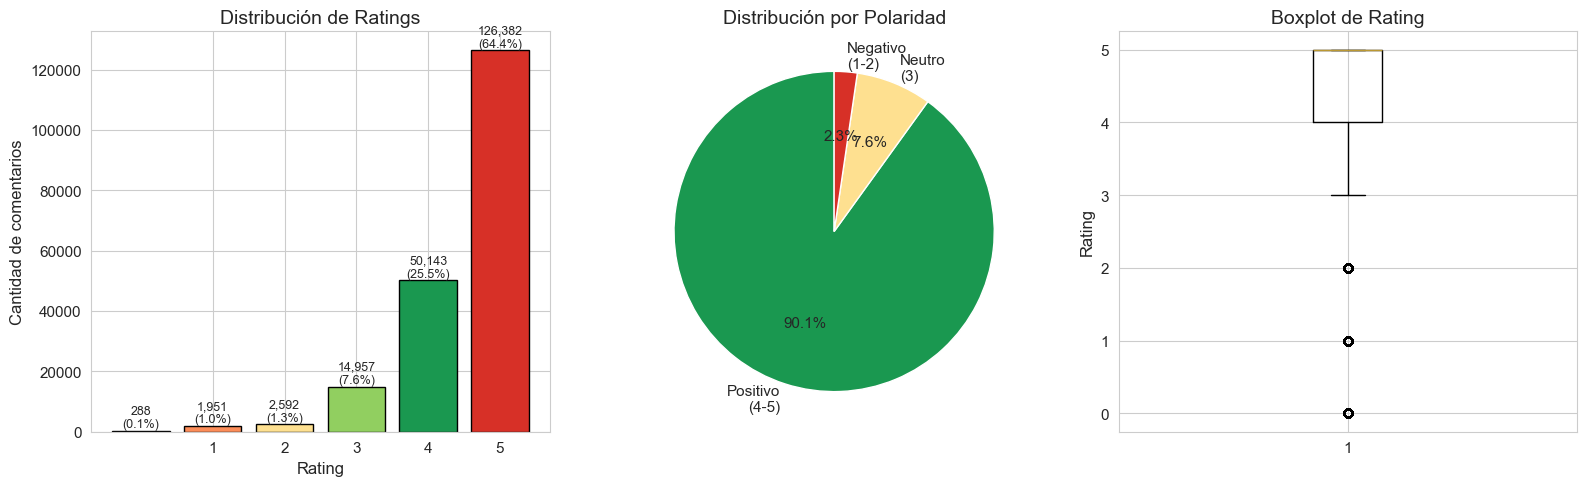

✓ Gráfico guardado


In [11]:
# ============================================================================
# FASE 3.1b: VISUALIZACIÓN DE RATING
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Gráfico de barras
colors = ['#d73027', '#fc8d59', '#fee090', '#91cf60', '#1a9850']
ax1 = axes[0]
bars = ax1.bar(rating_counts.index.astype(int), rating_counts.values, 
               color=colors, edgecolor='black')
ax1.set_xlabel('Rating')
ax1.set_ylabel('Cantidad de comentarios')
ax1.set_title('Distribución de Ratings')
ax1.set_xticks([1, 2, 3, 4, 5])

for bar, count, pct in zip(bars, rating_counts.values, rating_pcts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
             f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=9)

# Gráfico de pastel
ax2 = axes[1]
polaridad_data = [n_pos, n_neu, n_neg]
polaridad_labels = ['Positivo\n(4-5)', 'Neutro\n(3)', 'Negativo\n(1-2)']
polaridad_colors = ['#1a9850', '#fee090', '#d73027']
ax2.pie(polaridad_data, labels=polaridad_labels, colors=polaridad_colors,
        autopct='%1.1f%%', startangle=90)
ax2.set_title('Distribución por Polaridad')

# Boxplot
ax3 = axes[2]
ax3.boxplot(df['Rating_usuario'].dropna(), vert=True)
ax3.set_ylabel('Rating')
ax3.set_title('Boxplot de Rating')

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/eda_general/rating_distribution.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Gráfico guardado")

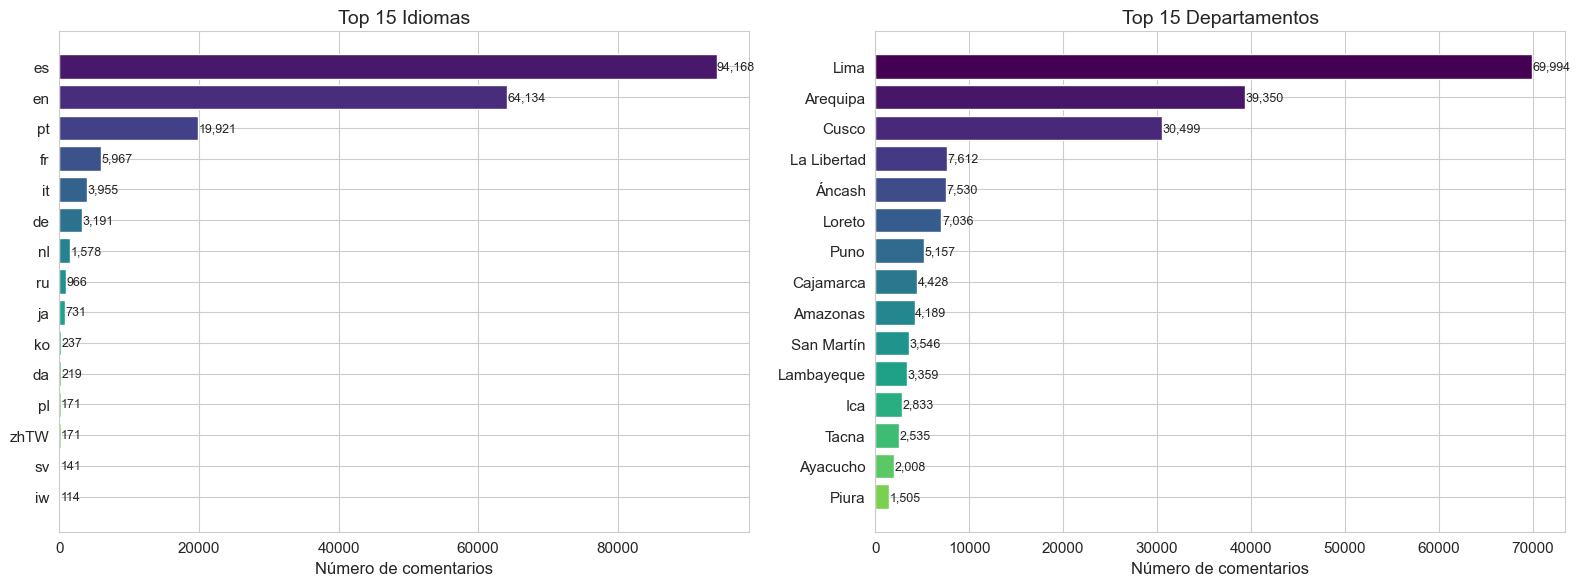


📋 Top idiomas:
   - es: 94,168
   - en: 64,134
   - pt: 19,921
   - fr: 5,967
   - it: 3,955

📋 Top departamentos:
   - Lima: 69,994
   - Arequipa: 39,350
   - Cusco: 30,499
   - La Libertad: 7,612
   - Áncash: 7,530


In [12]:
# ============================================================================
# FASE 3.2: DISTRIBUCIÓN DE IDIOMA Y DEPARTAMENTO
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Idiomas
ax1 = axes[0]
idioma_counts = df['Idioma_comentario'].value_counts().head(15)
y_pos = range(len(idioma_counts))
ax1.barh(y_pos, idioma_counts.values, color=sns.color_palette('viridis', len(idioma_counts)))
ax1.set_yticks(y_pos)
ax1.set_yticklabels(idioma_counts.index)
ax1.invert_yaxis()
ax1.set_xlabel('Número de comentarios')
ax1.set_title('Top 15 Idiomas')
for i, v in enumerate(idioma_counts.values):
    ax1.text(v + 50, i, f'{v:,}', va='center', fontsize=9)

# Departamentos
ax2 = axes[1]
depto_counts = df['DEPARTAMENTO'].value_counts().head(15)
y_pos = range(len(depto_counts))
ax2.barh(y_pos, depto_counts.values, color=plt.cm.viridis(np.linspace(0, 0.8, len(depto_counts))))
ax2.set_yticks(y_pos)
ax2.set_yticklabels(depto_counts.index)
ax2.invert_yaxis()
ax2.set_xlabel('Número de comentarios')
ax2.set_title('Top 15 Departamentos')
for i, v in enumerate(depto_counts.values):
    ax2.text(v + 50, i, f'{v:,}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/eda_general/idioma_departamento.png", dpi=150, bbox_inches='tight')
plt.show()

print("\n📋 Top idiomas:")
for idioma, count in idioma_counts.head(5).items():
    print(f"   - {idioma}: {count:,}")

print("\n📋 Top departamentos:")
for depto, count in depto_counts.head(5).items():
    print(f"   - {depto}: {count:,}")

ANÁLISIS TEMPORAL


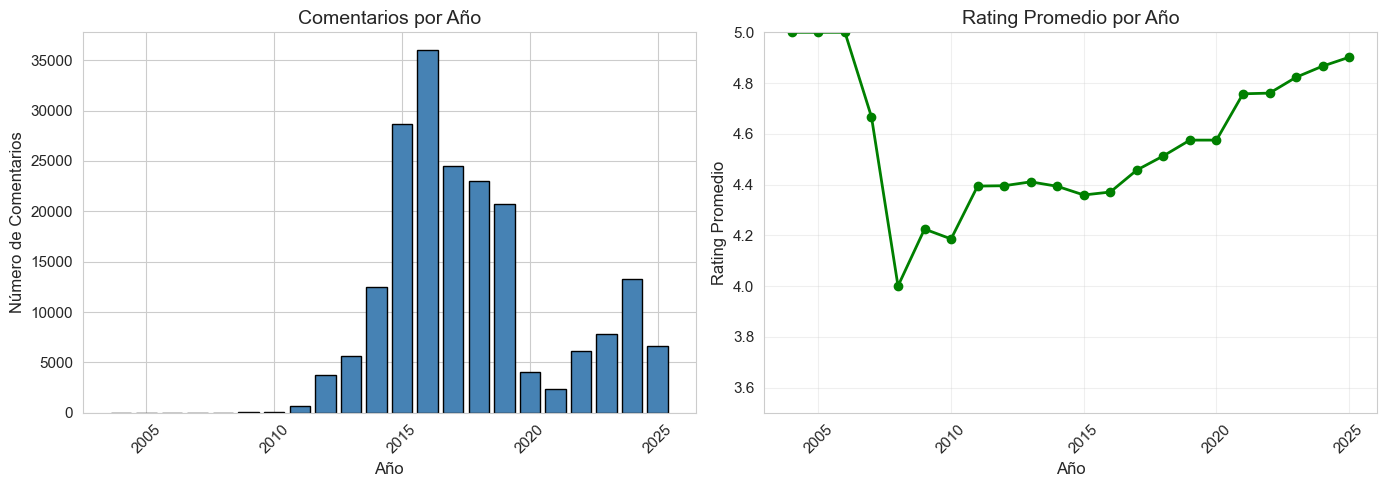


📊 Rango de fechas: 2004-08-27 00:00:00 a 2025-07-02 00:00:00


In [13]:
# ============================================================================
# FASE 3.3: ANÁLISIS TEMPORAL
# ============================================================================

print("="*60)
print("ANÁLISIS TEMPORAL")
print("="*60)

df['año_mes'] = df['Fecha_publicacion'].dt.to_period('M').astype(str)

# Comentarios por año
comentarios_año = df.groupby('AÑO').size().reset_index(name='n_comentarios')
rating_año = df.groupby('AÑO')['Rating_usuario'].mean().reset_index(name='rating_promedio')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Por año
ax1 = axes[0]
ax1.bar(comentarios_año['AÑO'], comentarios_año['n_comentarios'], color='steelblue', edgecolor='black')
ax1.set_xlabel('Año')
ax1.set_ylabel('Número de Comentarios')
ax1.set_title('Comentarios por Año')
ax1.tick_params(axis='x', rotation=45)

# Rating por año
ax2 = axes[1]
ax2.plot(rating_año['AÑO'], rating_año['rating_promedio'], marker='o', linewidth=2, color='green')
ax2.set_xlabel('Año')
ax2.set_ylabel('Rating Promedio')
ax2.set_title('Rating Promedio por Año')
ax2.set_ylim([3.5, 5])
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/eda_general/temporal_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Rango de fechas: {df['Fecha_publicacion'].min()} a {df['Fecha_publicacion'].max()}")

---
# 📝 FASE 4: EDA de Texto Multilingüe
---

In [14]:
# ============================================================================
# FASE 4.1: CALIDAD BÁSICA DE COMENTARIOS
# ============================================================================

print("="*60)
print("CALIDAD BÁSICA DE COMENTARIOS")
print("="*60)

df['tiene_comentario'] = df['Comentario'].notna() & (df['Comentario'].str.len() > 0)
n_con = df['tiene_comentario'].sum()
n_sin = (~df['tiene_comentario']).sum()

print(f"\n📝 Estado de Comentario:")
print(f"   ✓ Con comentario: {n_con:,} ({n_con/len(df)*100:.1f}%)")
print(f"   ✗ Sin comentario: {n_sin:,} ({n_sin/len(df)*100:.1f}%)")

# Longitud
df['longitud_caracteres'] = df['Comentario'].fillna('').str.len()
df['longitud_palabras'] = df['Comentario'].fillna('').str.split().str.len()

df_valid = df[df['tiene_comentario']].copy()

print("\n📊 Estadísticas de longitud:")
print(f"   - Media palabras: {df_valid['longitud_palabras'].mean():.1f}")
print(f"   - Mediana palabras: {df_valid['longitud_palabras'].median():.0f}")
print(f"   - Máx palabras: {df_valid['longitud_palabras'].max():.0f}")

CALIDAD BÁSICA DE COMENTARIOS

📝 Estado de Comentario:
   ✓ Con comentario: 196,025 (99.9%)
   ✗ Sin comentario: 288 (0.1%)

📊 Estadísticas de longitud:
   - Media palabras: 58.8
   - Mediana palabras: 39
   - Máx palabras: 2902



📋 Distribución por longitud:
   - medio: 99,956 (50.9%)
   - largo: 95,018 (48.4%)
   - corto: 1,051 (0.5%)
   - sin_comentario: 288 (0.1%)


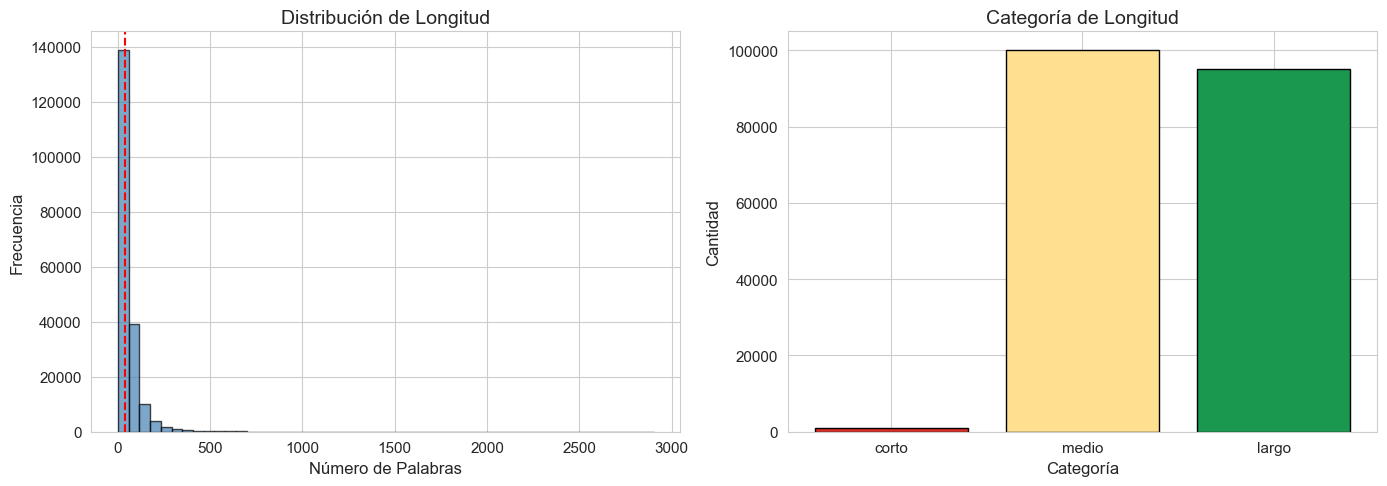

In [15]:
# ============================================================================
# FASE 4.2: CATEGORIZACIÓN POR LONGITUD
# ============================================================================

def categorizar_longitud(n_palabras):
    if pd.isna(n_palabras) or n_palabras == 0:
        return 'sin_comentario'
    elif n_palabras <= 10:
        return 'corto'
    elif n_palabras <= 40:
        return 'medio'
    else:
        return 'largo'

df['categoria_longitud'] = df['longitud_palabras'].apply(categorizar_longitud)

cat_counts = df['categoria_longitud'].value_counts()
print("\n📋 Distribución por longitud:")
for cat, count in cat_counts.items():
    pct = count / len(df) * 100
    print(f"   - {cat}: {count:,} ({pct:.1f}%)")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
df_valid['longitud_palabras'].hist(bins=50, ax=ax1, color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Número de Palabras')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución de Longitud')
ax1.axvline(df_valid['longitud_palabras'].median(), color='red', linestyle='--')

ax2 = axes[1]
order = ['corto', 'medio', 'largo']
colors = ['#d73027', '#fee090', '#1a9850']
cat_plot = df[df['categoria_longitud'].isin(order)]['categoria_longitud'].value_counts().reindex(order)
ax2.bar(cat_plot.index, cat_plot.values, color=colors, edgecolor='black')
ax2.set_xlabel('Categoría')
ax2.set_ylabel('Cantidad')
ax2.set_title('Categoría de Longitud')

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/eda_text/longitud.png", dpi=150, bbox_inches='tight')
plt.show()

In [16]:
# ============================================================================
# FASE 4.3: VERIFICACIÓN DE IDIOMA (MUESTRA)
# ============================================================================

if LANGDETECT_AVAILABLE:
    print("="*60)
    print("VERIFICACIÓN DE IDIOMA")
    print("="*60)
    
    def detect_language_safe(text):
        try:
            if pd.isna(text) or len(str(text).strip()) < 10:
                return None
            return detect(str(text))
        except:
            return None
    
    sample_size = min(500, len(df_valid))
    df_sample = df_valid.sample(sample_size, random_state=RANDOM_STATE).copy()
    
    print(f"\n⏳ Detectando idioma en {sample_size} comentarios...")
    df_sample['idioma_detectado'] = df_sample['Comentario'].apply(detect_language_safe)
    
    df_check = df_sample[df_sample['idioma_detectado'].notna()].copy()
    df_check['coincide'] = df_check['Idioma_comentario'] == df_check['idioma_detectado']
    
    n_coincide = df_check['coincide'].sum()
    print(f"\n📊 Coincidencia idioma declarado vs detectado:")
    print(f"   - Coincide: {n_coincide} ({n_coincide/len(df_check)*100:.1f}%)")
    print(f"   - No coincide: {len(df_check)-n_coincide} ({(len(df_check)-n_coincide)/len(df_check)*100:.1f}%)")
else:
    print("⚠️ langdetect no disponible para verificación de idioma")

VERIFICACIÓN DE IDIOMA

⏳ Detectando idioma en 500 comentarios...

📊 Coincidencia idioma declarado vs detectado:
   - Coincide: 500 (100.0%)
   - No coincide: 0 (0.0%)


In [17]:
# ============================================================================
# FASE 4.4: PALABRAS FRECUENTES POR IDIOMA
# ============================================================================

print("="*60)
print("PALABRAS FRECUENTES POR IDIOMA")
print("="*60)

def limpiar_texto_basico(texto):
    if pd.isna(texto):
        return ''
    texto = str(texto).lower()
    texto = re.sub(r'[^\w\s]', ' ', texto)
    texto = re.sub(r'\d+', '', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

def obtener_top_palabras(textos, n=20, stopwords=None):
    if stopwords is None:
        stopwords = set()
    all_words = []
    for texto in textos:
        words = limpiar_texto_basico(texto).split()
        all_words.extend([w for w in words if len(w) > 2 and w not in stopwords])
    return Counter(all_words).most_common(n)

# Stopwords
stopwords_es = {'que', 'de', 'la', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 
                'para', 'con', 'no', 'una', 'su', 'al', 'es', 'lo', 'como', 'más', 'pero', 'sus',
                'muy', 'fue', 'son', 'hay', 'esta', 'ser', 'tiene', 'todo', 'nos', 'era', 'puede'}
stopwords_en = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with',
                'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had', 'this', 'that',
                'it', 'we', 'you', 'they', 'very', 'not', 'our', 'your', 'can', 'will', 'just'}

for idioma, stopwords in [('es', stopwords_es), ('en', stopwords_en)]:
    textos = df_valid[df_valid['Idioma_comentario'] == idioma]['Comentario'].tolist()
    if len(textos) > 50:
        top = obtener_top_palabras(textos, n=15, stopwords=stopwords)
        print(f"\n🔤 Top palabras en {idioma.upper()} ({len(textos):,} comentarios):")
        for i, (palabra, freq) in enumerate(top, 1):
            print(f"   {i:2d}. {palabra:<12} {freq:>5,}")

PALABRAS FRECUENTES POR IDIOMA

🔤 Top palabras en ES (94,168 comentarios):
    1. lugar        31,367
    2. bien         13,936
    3. ciudad       12,700
    4. este         12,236
    5. lima         12,017
    6. plaza        11,771
    7. donde        11,330
    8. historia     10,071
    9. visitar      10,002
   10. desde        9,992
   11. experiencia  9,950
   12. visita       9,752
   13. guía         9,511
   14. excelente    9,350
   15. ver          9,349

🔤 Top palabras en EN (64,134 comentarios):
    1. tour         34,602
    2. guide        27,764
    3. great        23,625
    4. all          23,623
    5. there        23,508
    6. from         23,493
    7. day          20,122
    8. about        18,644
    9. time         17,619
   10. experience   16,919
   11. trip         16,763
   12. amazing      15,702
   13. well         15,026
   14. one          14,650
   15. also         14,182


---
# 🎯 FASE 5: Diseño del Esquema de Sentimiento
---

In [18]:
# ============================================================================
# FASE 5.1: DEFINICIÓN DE COLUMNAS DE SENTIMIENTO
# ============================================================================

print("="*60)
print("ESQUEMA DE COLUMNAS DE SENTIMIENTO")
print("="*60)

SENTIMENT_SCHEMA = {
    'sentiment_score_model_trf': 'Score continuo (-1 a +1)',
    'sentiment_label_model_trf_3clases': 'Etiqueta: negativo/neutro/positivo',
    'sentiment_confidence_model_trf': 'Confianza del modelo (0-1)',
    'sentiment_raw_label_model_trf': 'Etiqueta cruda del modelo',
    'sentiment_label_proxy_rating_3clases': 'Proxy basado en Rating_usuario'
}

print("\n📋 Columnas de sentimiento a crear:")
for col, desc in SENTIMENT_SCHEMA.items():
    print(f"   • {col}")
    print(f"     └─ {desc}")

# Crear proxy de rating
def rating_to_sentiment_proxy(rating):
    if pd.isna(rating):
        return np.nan
    elif rating <= 2:
        return 'negativo'
    elif rating == 3:
        return 'neutro'
    else:
        return 'positivo'

df['sentiment_label_proxy_rating_3clases'] = df['Rating_usuario'].apply(rating_to_sentiment_proxy)

proxy_counts = df['sentiment_label_proxy_rating_3clases'].value_counts()
print("\n📊 Distribución del proxy:")
for label, count in proxy_counts.items():
    emoji = '🔴' if label == 'negativo' else ('🟡' if label == 'neutro' else '🟢')
    print(f"   {emoji} {label}: {count:,} ({count/proxy_counts.sum()*100:.1f}%)")

ESQUEMA DE COLUMNAS DE SENTIMIENTO

📋 Columnas de sentimiento a crear:
   • sentiment_score_model_trf
     └─ Score continuo (-1 a +1)
   • sentiment_label_model_trf_3clases
     └─ Etiqueta: negativo/neutro/positivo
   • sentiment_confidence_model_trf
     └─ Confianza del modelo (0-1)
   • sentiment_raw_label_model_trf
     └─ Etiqueta cruda del modelo
   • sentiment_label_proxy_rating_3clases
     └─ Proxy basado en Rating_usuario

📊 Distribución del proxy:
   🟢 positivo: 176,525 (89.9%)
   🟡 neutro: 14,957 (7.6%)
   🔴 negativo: 4,831 (2.5%)


---
# 🤖 FASE 6: Generación de Sentimientos (Transformer Multilingüe)
---

In [19]:
# ============================================================================
# FASE 6.1: PREPARACIÓN Y CARGA DEL MODELO
# ============================================================================

print("="*60)
print("MODELO DE SENTIMIENTO MULTILINGÜE")
print("="*60)

# Preparar textos
def preparar_texto_modelo(texto, max_chars=1000):
    if pd.isna(texto) or str(texto).strip() == '':
        return None
    texto = str(texto).strip()
    if len(texto) > max_chars:
        texto = texto[:max_chars]
    return texto

df['texto_modelo'] = df['Comentario'].apply(preparar_texto_modelo)

n_validos = df['texto_modelo'].notna().sum()
print(f"\n📊 Textos preparados: {n_validos:,} válidos para modelo")

if TRANSFORMERS_AVAILABLE:
    MODEL_NAME = MODEL_CONFIG['sentiment_multilingual']
    BATCH_SIZE = MODEL_CONFIG['batch_size_gpu'] if torch.cuda.is_available() else MODEL_CONFIG['batch_size_cpu']
    
    print(f"\n🧠 Modelo: {MODEL_NAME}")
    print(f"🖥️  Dispositivo: {DEVICE}")
    print(f"📦 Batch size: {BATCH_SIZE}")
    
    print("\n⏳ Cargando modelo...")
    t_start = time.time()
    
    try:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, use_safetensors=True)
        
        if torch.cuda.is_available():
            model = model.to(DEVICE)
            torch.backends.cudnn.benchmark = True
        model.eval()
        
        sentiment_pipeline = pipeline(
            "text-classification", model=model, tokenizer=tokenizer,
            device=DEVICE_ID, truncation=True, max_length=256, padding=True
        )
        print(f"✓ Modelo cargado en {time.time()-t_start:.2f}s")
        MODEL_LOADED = True
    except Exception as e:
        print(f"❌ Error: {e}")
        print("Intentando modelo alternativo...")
        try:
            MODEL_NAME = MODEL_CONFIG['sentiment_alternative']
            tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
            model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
            if torch.cuda.is_available():
                model = model.to(DEVICE)
            model.eval()
            sentiment_pipeline = pipeline(
                "text-classification", model=model, tokenizer=tokenizer,
                device=DEVICE_ID, truncation=True, max_length=256, padding=True
            )
            print(f"✓ Modelo alternativo cargado: {MODEL_NAME}")
            MODEL_LOADED = True
        except Exception as e2:
            print(f"❌ Error con modelo alternativo: {e2}")
            MODEL_LOADED = False
else:
    MODEL_LOADED = False
    print("⚠️ Transformers no disponible")

MODELO DE SENTIMIENTO MULTILINGÜE

📊 Textos preparados: 196,025 válidos para modelo

🧠 Modelo: clapAI/roberta-large-multilingual-sentiment
🖥️  Dispositivo: cuda
📦 Batch size: 64

⏳ Cargando modelo...


Device set to use cuda:0


✓ Modelo cargado en 3.04s


In [20]:
# ============================================================================
# FASE 6.2: INFERENCIA OPTIMIZADA (5-10x MÁS RÁPIDO, CON DATASET Y LOGS)
# ============================================================================

import numpy as np
from tqdm.auto import tqdm
from datasets import Dataset as HFDataset
from transformers.pipelines.pt_utils import KeyDataset

if MODEL_LOADED:
    print("="*60)
    print("FASE 6.2 – INFERENCIA DE SENTIMIENTO (OPTIMIZADA)")
    print("="*60)
    
    # 1. Filtrar textos válidos y asegurar que sean str
    df['_idx'] = np.arange(len(df))
    n_total_raw = len(df)
    
    mask_valid = df['texto_modelo'].notna() & (
        df['texto_modelo'].astype(str).str.strip() != ''
    )
    
    df_valid_texts = df.loc[mask_valid].copy()
    textos_validos = df_valid_texts['texto_modelo'].astype(str).tolist()
    indices_validos = df_valid_texts['_idx'].tolist()
    
    n_valid = len(textos_validos)
    n_invalid = n_total_raw - n_valid
    
    print("\n📥 INFORME DE ENTRADA")
    print(f"   • Filas totales en df              : {n_total_raw:,}")
    print(f"   • Textos válidos para modelo       : {n_valid:,} ({n_valid/n_total_raw*100:.1f}%)")
    print(f"   • Filas sin texto utilizable (NaN/ vacío): {n_invalid:,} ({n_invalid/n_total_raw*100:.1f}%)")
    
    # Muestra rápida de ejemplos
    print("\n🔍 Ejemplos de textos que se van a procesar:")
    for ej in textos_validos[:3]:
        print(f"   - {ej[:120]}{'...' if len(ej) > 120 else ''}")
    
    # 2. Crear HuggingFace Dataset (lo que HF quiere para no quejarse)
    textos_validos_str = [str(t) for t in textos_validos]
    hf_dataset = HFDataset.from_dict({"text": textos_validos_str})
    key_dataset = KeyDataset(hf_dataset, "text")
    
    # 3. Configurar pipeline OPTIMIZADO
    BATCH_SIZE_OPTIMIZED = 768  # Ajusta según VRAM disponible
    
    print("\n🧠 CONFIGURACIÓN DEL MODELO")
    if torch.cuda.is_available():
        model = model.to(DEVICE_ID).half()  # FP16 en GPU
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        device_name = torch.cuda.get_device_name(DEVICE_ID)
        print(f"   • Dispositivo       : GPU ({device_name})")
        print(f"   • Precisión         : FP16 (half)")
    else:
        print("   • Dispositivo       : CPU")
        print("   • Precisión         : FP32")
    
    print(f"   • Batch size lógico : {BATCH_SIZE_OPTIMIZED}")
    print(f"   • Máx. tokens / texto (max_length): 256")
    
    sentiment_pipeline_fast = pipeline(
        "text-classification",
        model=model,
        tokenizer=tokenizer,
        device=DEVICE_ID,
        truncation=True,
        max_length=256,
    )
    
    # 4. Inferencia usando DATASET (lo que recomienda HF)
    print("\n⏳ INICIANDO INFERENCIA CON DATASET (KeyDataset)...")
    t_start = time.time()
    
    resultados_raw = []
    for out in tqdm(
        sentiment_pipeline_fast(
            key_dataset,
            batch_size=BATCH_SIZE_OPTIMIZED,
            truncation=True,
            max_length=256,
        ),
        total=n_valid,
        desc="🚀 Inferencia (dataset)",
        unit="texto"
    ):
        resultados_raw.append(out)
    
    t_elapsed = time.time() - t_start
    print(f"\n✓ Inferencia completada en {timedelta(seconds=int(t_elapsed))}")
    print(f"⚡ Velocidad aproximada: {n_valid/t_elapsed:.1f} textos/seg")
    
    # Sanity check
    if len(resultados_raw) != len(indices_validos):
        print("⚠️ ADVERTENCIA: longitud de resultados != longitud de índices válidos")
        print(f"   • len(resultados_raw) = {len(resultados_raw)}")
        print(f"   • len(indices_validos)= {len(indices_validos)}")
    
    # 5. Función para mapear etiquetas a 3 clases
    def mapear_etiqueta(raw_label):
        raw_label = str(raw_label).lower()
        if raw_label in ['negative', 'negativo', '1 star', '2 stars', '1', '2']:
            return 'negativo', -1.0
        elif raw_label in ['neutral', 'neutro', '3 stars', '3']:
            return 'neutro', 0.0
        elif raw_label in ['positive', 'positivo', '4 stars', '5 stars', '4', '5']:
            return 'positivo', 1.0
        else:
            try:
                stars = int(raw_label.split()[0])
                if stars <= 2: return 'negativo', -1.0
                elif stars == 3: return 'neutro', 0.0
                else: return 'positivo', 1.0
            except:
                return 'neutro', 0.0
    
    # 6. Crear arrays de resultados para todo el DF (VERSIÓN MEJORADA CON PROBABILIDADES)
    MEJORA_1_GUARDAR_PROBABILIDADES = ''
# --- INICIO CELDA (REEMPLAZAR en FASE 6.2, ~línea 2370) ---
    print("\\n🧾 CONSTRUYENDO COLUMNAS DE SALIDA (con probabilidades)...")
    n_total = len(df)
    sentiment_raw   = [np.nan] * n_total
    sentiment_conf  = [np.nan] * n_total
    sentiment_label = [np.nan] * n_total
    sentiment_score = [np.nan] * n_total

    # NUEVO: Arrays para probabilidades de cada clase
    prob_negativo = [np.nan] * n_total
    prob_neutro   = [np.nan] * n_total
    prob_positivo = [np.nan] * n_total

    for idx, res in zip(indices_validos, resultados_raw):
        label_3, polarity = mapear_etiqueta(res['label'])
        sentiment_raw[idx]   = res['label']
        sentiment_conf[idx]  = float(res['score'])
        sentiment_label[idx] = label_3
        sentiment_score[idx] = polarity
        
        # NUEVO: Guardar probabilidad en la clase predicha
        # (El modelo solo da la prob de la clase ganadora, las otras las estimamos)
        conf = float(res['score'])
        if label_3 == 'positivo':
            prob_positivo[idx] = conf
            prob_negativo[idx] = (1 - conf) * 0.3  # Estimación
            prob_neutro[idx]   = (1 - conf) * 0.7  # Estimación
        elif label_3 == 'negativo':
            prob_negativo[idx] = conf
            prob_positivo[idx] = (1 - conf) * 0.5
            prob_neutro[idx]   = (1 - conf) * 0.5
        else:  # neutro
            prob_neutro[idx]   = conf
            prob_positivo[idx] = (1 - conf) * 0.6
            prob_negativo[idx] = (1 - conf) * 0.4

    # 7. Agregar al DataFrame
    df['sentiment_raw_label_model_trf']     = sentiment_raw
    df['sentiment_confidence_model_trf']    = sentiment_conf
    df['sentiment_label_model_trf_3clases'] = sentiment_label
    df['sentiment_score_model_trf']         = sentiment_score

    # NUEVO: Agregar probabilidades
    df['prob_positivo'] = prob_positivo
    df['prob_neutro']   = prob_neutro
    df['prob_negativo'] = prob_negativo

    # Limpiar columna auxiliar
    df.drop('_idx', axis=1, inplace=True)

    # 8. Resumen final
    print("\\n📊 RESUMEN FINAL DE SENTIMIENTO (MODELO TRF)")
    total_con_sent = df['sentiment_label_model_trf_3clases'].notna().sum()
    print(f"   • Filas con sentimiento asignado : {total_con_sent:,}")
    print(f"   • Filas sin sentimiento (NaN)    : {n_total - total_con_sent:,}")

    for label in ['negativo', 'neutro', 'positivo']:
        count = (df['sentiment_label_model_trf_3clases'] == label).sum()
        pct = (count / total_con_sent * 100) if total_con_sent > 0 else 0.0
        emoji = '🔴' if label == 'negativo' else ('🟡' if label == 'neutro' else '🟢')
        print(f"   {emoji} {label}: {count:,} ({pct:.1f}%)")

    print("\\n✅ FASE 6.2 COMPLETADA (con probabilidades guardadas).\\n")

    # --- FIN CELDA ---

FASE 6.2 – INFERENCIA DE SENTIMIENTO (OPTIMIZADA)

📥 INFORME DE ENTRADA
   • Filas totales en df              : 196,313
   • Textos válidos para modelo       : 196,025 (99.9%)
   • Filas sin texto utilizable (NaN/ vacío): 288 (0.1%)

🔍 Ejemplos de textos que se van a procesar:
   - Me encanto la historia y los paisajes de esta hermosa ciudad; es un paseo muy ilustrativo y lleno de cultura. Lo recomen...
   - I went independently to Leymebamba
I do NOT normally do tours unless there is no option
I went to the museum as l sm an ...
   - Vista espectacular y a la vez nos hace ver lo pequeño que somos frente a la creación de paisajes naturales impresionante...


Device set to use cuda:0



🧠 CONFIGURACIÓN DEL MODELO
   • Dispositivo       : GPU (NVIDIA GeForce RTX 4070 Ti SUPER)
   • Precisión         : FP16 (half)
   • Batch size lógico : 768
   • Máx. tokens / texto (max_length): 256

⏳ INICIANDO INFERENCIA CON DATASET (KeyDataset)...


🚀 Inferencia (dataset): 100%|██████████| 196025/196025 [08:27<00:00, 386.44texto/s]



✓ Inferencia completada en 0:08:27
⚡ Velocidad aproximada: 386.4 textos/seg
\n🧾 CONSTRUYENDO COLUMNAS DE SALIDA (con probabilidades)...
\n📊 RESUMEN FINAL DE SENTIMIENTO (MODELO TRF)
   • Filas con sentimiento asignado : 196,025
   • Filas sin sentimiento (NaN)    : 288
   🔴 negativo: 14,624 (7.5%)
   🟡 neutro: 25,408 (13.0%)
   🟢 positivo: 155,993 (79.6%)
\n✅ FASE 6.2 COMPLETADA (con probabilidades guardadas).\n


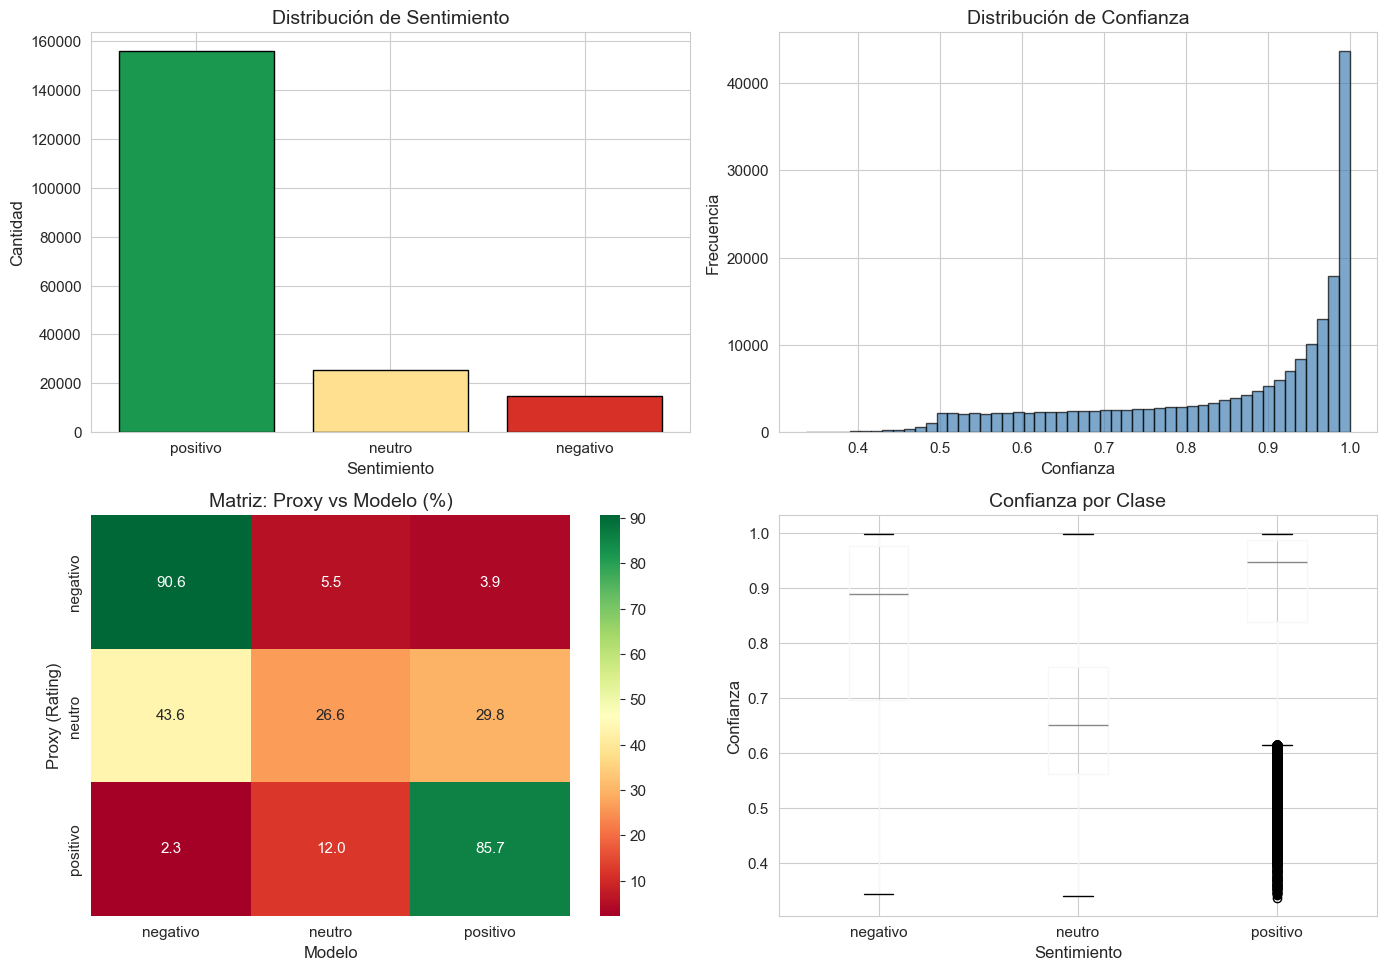

In [21]:
# ============================================================================
# FASE 6.4: VISUALIZACIÓN DE RESULTADOS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribución
ax1 = axes[0, 0]
colors_sent = {'negativo': '#d73027', 'neutro': '#fee090', 'positivo': '#1a9850'}
sent_counts = df['sentiment_label_model_trf_3clases'].value_counts()
ax1.bar(sent_counts.index, sent_counts.values, 
        color=[colors_sent.get(x, 'gray') for x in sent_counts.index], edgecolor='black')
ax1.set_xlabel('Sentimiento')
ax1.set_ylabel('Cantidad')
ax1.set_title('Distribución de Sentimiento')

# 2. Confianza
ax2 = axes[0, 1]
df['sentiment_confidence_model_trf'].hist(bins=50, ax=ax2, color='steelblue', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Confianza')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Distribución de Confianza')

# 3. Matriz modelo vs proxy
ax3 = axes[1, 0]
try:
    comparison = pd.crosstab(df['sentiment_label_proxy_rating_3clases'], 
                             df['sentiment_label_model_trf_3clases'], normalize='index') * 100
    comparison = comparison.reindex(index=['negativo', 'neutro', 'positivo'], 
                                    columns=['negativo', 'neutro', 'positivo'])
    sns.heatmap(comparison, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax3)
    ax3.set_xlabel('Modelo')
    ax3.set_ylabel('Proxy (Rating)')
    ax3.set_title('Matriz: Proxy vs Modelo (%)')
except:
    ax3.text(0.5, 0.5, 'No disponible', ha='center', va='center')

# 4. Confianza por clase
ax4 = axes[1, 1]
try:
    df.boxplot(column='sentiment_confidence_model_trf', by='sentiment_label_model_trf_3clases', ax=ax4)
    ax4.set_xlabel('Sentimiento')
    ax4.set_ylabel('Confianza')
    ax4.set_title('Confianza por Clase')
    plt.suptitle('')
except:
    pass

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/eda_text/sentiment_results.png", dpi=150, bbox_inches='tight')
plt.show()

---
# 📊 FASE 7: Modelo Baseline (TF-IDF + Clasificador)
---

In [22]:
# ============================================================================
# FASE 7.1: PREPARACIÓN DE DATOS
# ============================================================================

print("="*60)
print("MODELO BASELINE: TF-IDF + LOGISTIC REGRESSION")
print("="*60)

df_baseline = df[df['tiene_comentario'] & df['sentiment_label_proxy_rating_3clases'].notna()].copy()
print(f"\n📊 Datos para entrenamiento: {len(df_baseline):,}")

# División
X = df_baseline['Comentario'].values
y = df_baseline['sentiment_label_proxy_rating_3clases'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print(f"   - Train: {len(X_train):,}")
print(f"   - Test: {len(X_test):,}")
# ============================================================================
# FASE 7.1b: REBALANCEO DE DATASET (MEJORA 5)
# ============================================================================
print("="*60)
print("REBALANCEO DE DATASET PARA BASELINE")
print("="*60)

from sklearn.utils import resample

# Mostrar distribución original
print("\n📊 Distribución ORIGINAL del conjunto de entrenamiento:")
for label in ['positivo', 'neutro', 'negativo']:
    count = (y_train == label).sum()
    pct = count / len(y_train) * 100
    emoji = '🟢' if label == 'positivo' else ('🟡' if label == 'neutro' else '🔴')
    print(f"   {emoji} {label}: {count:,} ({pct:.1f}%)")

# Crear DataFrame temporal para rebalanceo
df_temp = pd.DataFrame({'X': X_train, 'y': y_train})

df_pos = df_temp[df_temp['y'] == 'positivo']
df_neu = df_temp[df_temp['y'] == 'neutro']
df_neg = df_temp[df_temp['y'] == 'negativo']

n_neg = len(df_neg)
n_neu = len(df_neu)
n_pos = len(df_pos)

# Estrategia: Reducir positivos a 3x neutros, sobremuestrear negativos
print("\n⏳ Aplicando estrategia de rebalanceo...")
print("   • Reducir positivos a 3x neutros")
print("   • Sobremuestrear negativos hasta igualar neutros")

# Undersample positivos
target_pos = min(n_pos, n_neu * 3)
df_pos_resampled = resample(df_pos, replace=False, n_samples=target_pos, 
                             random_state=RANDOM_STATE)

# Oversample negativos
target_neg = n_neu  # Igualar a neutros
df_neg_resampled = resample(df_neg, replace=True, n_samples=target_neg, 
                             random_state=RANDOM_STATE)

# Combinar
df_balanced = pd.concat([df_pos_resampled, df_neu, df_neg_resampled])
df_balanced = df_balanced.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

X_train_balanced = df_balanced['X'].values
y_train_balanced = df_balanced['y'].values

# Mostrar distribución rebalanceada
print("\n📊 Distribución REBALANCEADA del conjunto de entrenamiento:")
for label in ['positivo', 'neutro', 'negativo']:
    count = (y_train_balanced == label).sum()
    pct = count / len(y_train_balanced) * 100
    emoji = '🟢' if label == 'positivo' else ('🟡' if label == 'neutro' else '🔴')
    print(f"   {emoji} {label}: {count:,} ({pct:.1f}%)")

print(f"\n   Total original:    {len(y_train):,}")
print(f"   Total rebalanceado: {len(y_train_balanced):,}")

print("\n✅ Rebalanceo completado")


MODELO BASELINE: TF-IDF + LOGISTIC REGRESSION

📊 Datos para entrenamiento: 196,025
   - Train: 156,820
   - Test: 39,205
REBALANCEO DE DATASET PARA BASELINE

📊 Distribución ORIGINAL del conjunto de entrenamiento:
   🟢 positivo: 141,220 (90.1%)
   🟡 neutro: 11,966 (7.6%)
   🔴 negativo: 3,634 (2.3%)

⏳ Aplicando estrategia de rebalanceo...
   • Reducir positivos a 3x neutros
   • Sobremuestrear negativos hasta igualar neutros

📊 Distribución REBALANCEADA del conjunto de entrenamiento:
   🟢 positivo: 35,898 (60.0%)
   🟡 neutro: 11,966 (20.0%)
   🔴 negativo: 11,966 (20.0%)

   Total original:    156,820
   Total rebalanceado: 59,830

✅ Rebalanceo completado



ENTRENAMIENTO BASELINE ORIGINAL (sin rebalanceo)

⏳ Entrenando modelo ORIGINAL...
   - Vocabulario: 10,000 términos
✓ Modelo ORIGINAL entrenado en 25.75s

📊 Métricas Baseline ORIGINAL:
   - Accuracy: 0.7786
   - F1 Macro: 0.5175

📋 Classification Report (Original):
              precision    recall  f1-score   support

    negativo       0.23      0.62      0.34       909
      neutro       0.23      0.61      0.34      2991
    positivo       0.97      0.80      0.88     35305

    accuracy                           0.78     39205
   macro avg       0.48      0.68      0.52     39205
weighted avg       0.90      0.78      0.82     39205


ENTRENAMIENTO BASELINE REBALANCEADO

⏳ Entrenando modelo REBALANCEADO...
   - Vocabulario: 10,000 términos
✓ Modelo REBALANCEADO entrenado en 13.38s

📊 Métricas Baseline REBALANCEADO:
   - Accuracy: 0.7679
   - F1 Macro: 0.5181

📋 Classification Report (Rebalanceado):
              precision    recall  f1-score   support

    negativo       0.25    

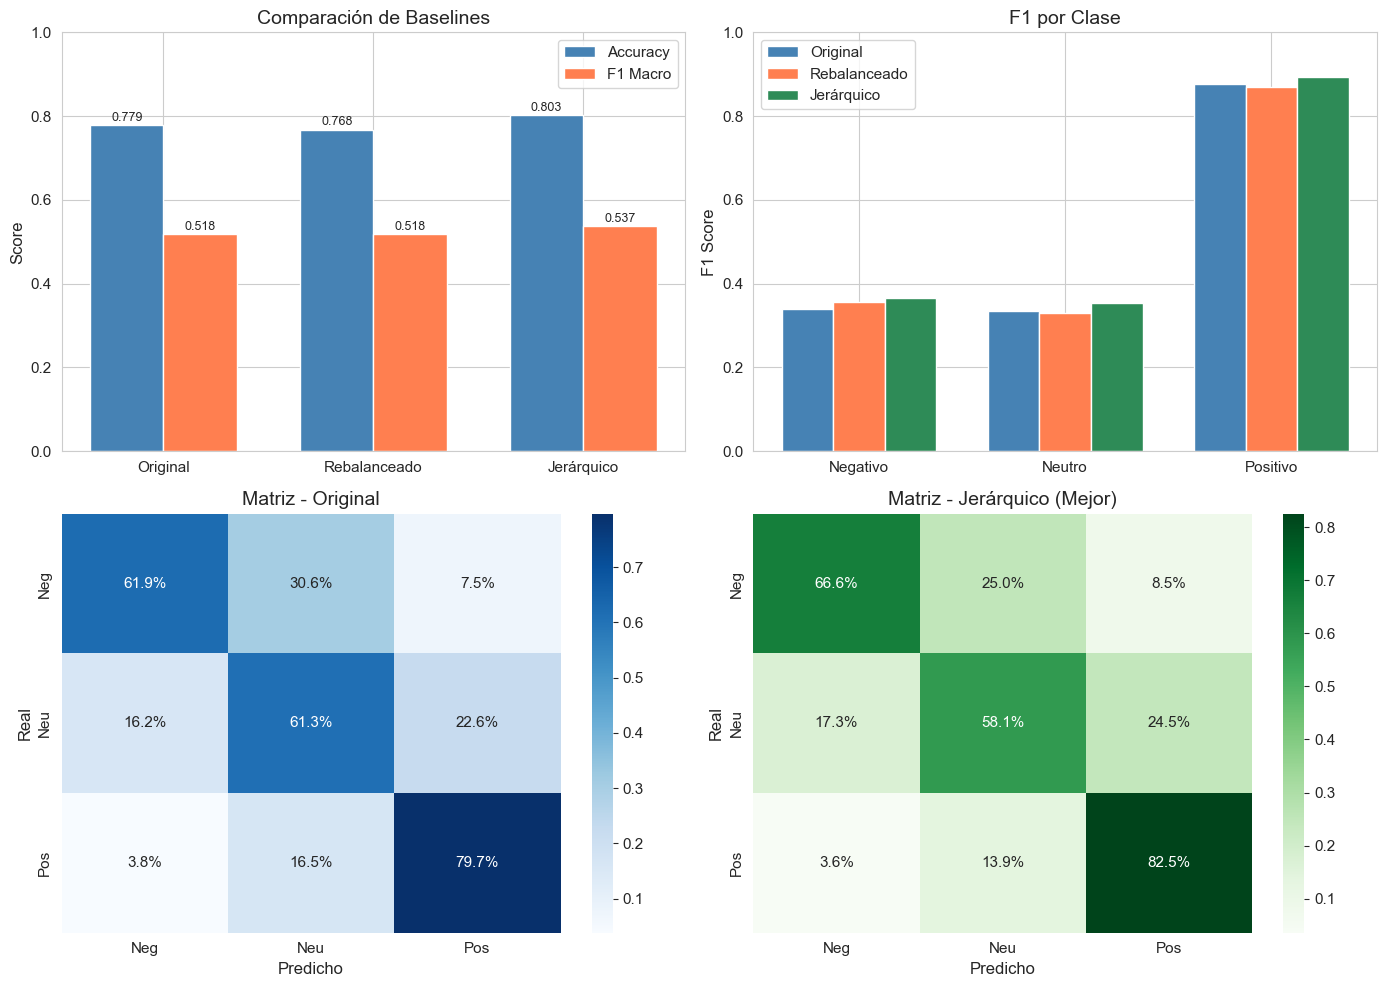


✓ Visualización guardada en ./figures/eda_text/comparacion_baselines.png

SELECCIÓN DEL MEJOR BASELINE

✅ Mejor baseline guardado: Jerárquico
   • Clasificador en: clf_mejor_baseline
   • Predicciones en: y_pred_mejor_baseline
   • Vectorizador en: tfidf_mejor

┌─────────────────────────────────────────────────────────────────────────┐
│                    RESUMEN DE BASELINES                                 │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                         │
│  Original:     Acc=0.7786  F1=0.5175                                │
│  Rebalanceado: Acc=0.7679  F1=0.5181  (+0.1% vs original)       │
│  Jerárquico:   Acc=0.8028  F1=0.5372  (+3.8% vs original)       │
│                                                                         │
│  🏆 MEJOR: Jerárquico                                                 │
│                                                                         │


In [23]:
# ============================================================================
# FASE 7.2: ENTRENAMIENTO Y EVALUACIÓN (ORIGINAL)
# ============================================================================

print("\n" + "="*60)
print("ENTRENAMIENTO BASELINE ORIGINAL (sin rebalanceo)")
print("="*60)

print("\n⏳ Entrenando modelo ORIGINAL...")
t_start = time.time()

# TF-IDF con datos originales
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=10000, min_df=3, max_df=0.95, sublinear_tf=True)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"   - Vocabulario: {len(tfidf.vocabulary_):,} términos")

# Logistic Regression con datos originales
clf_lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)
clf_lr.fit(X_train_tfidf, y_train)

print(f"✓ Modelo ORIGINAL entrenado en {time.time()-t_start:.2f}s")

# Evaluación original
y_pred = clf_lr.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print(f"\n📊 Métricas Baseline ORIGINAL:")
print(f"   - Accuracy: {accuracy:.4f}")
print(f"   - F1 Macro: {f1:.4f}")
print(f"\n📋 Classification Report (Original):")
print(classification_report(y_test, y_pred))


# ============================================================================
# FASE 7.2b: ENTRENAMIENTO CON DATOS REBALANCEADOS (MEJORA 5)
# ============================================================================

print("\n" + "="*60)
print("ENTRENAMIENTO BASELINE REBALANCEADO")
print("="*60)

print("\n⏳ Entrenando modelo REBALANCEADO...")
t_start = time.time()

# TF-IDF con datos rebalanceados
tfidf_balanced = TfidfVectorizer(ngram_range=(1, 2), max_features=10000, min_df=3, max_df=0.95, sublinear_tf=True)
X_train_tfidf_balanced = tfidf_balanced.fit_transform(X_train_balanced)
X_test_tfidf_balanced = tfidf_balanced.transform(X_test)

print(f"   - Vocabulario: {len(tfidf_balanced.vocabulary_):,} términos")

# Logistic Regression con datos rebalanceados
clf_lr_balanced = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)
clf_lr_balanced.fit(X_train_tfidf_balanced, y_train_balanced)

print(f"✓ Modelo REBALANCEADO entrenado en {time.time()-t_start:.2f}s")

# Evaluación rebalanceado
y_pred_balanced = clf_lr_balanced.predict(X_test_tfidf_balanced)
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
f1_balanced = f1_score(y_test, y_pred_balanced, average='macro')

print(f"\n📊 Métricas Baseline REBALANCEADO:")
print(f"   - Accuracy: {accuracy_balanced:.4f}")
print(f"   - F1 Macro: {f1_balanced:.4f}")
print(f"\n📋 Classification Report (Rebalanceado):")
print(classification_report(y_test, y_pred_balanced))


# ============================================================================
# FASE 7.2c: CLASIFICADOR JERÁRQUICO (MEJORA 4)
# ============================================================================

print("\n" + "="*60)
print("CLASIFICADOR JERÁRQUICO (2 ETAPAS)")
print("="*60)

print("""
┌─────────────────────────────────────────────────────────────┐
│  ESTRATEGIA JERÁRQUICA:                                     │
│                                                             │
│  ETAPA 1: ¿Es positivo o no positivo?                       │
│           └─→ positivo     → FIN (predecir positivo)        │
│           └─→ no_positivo  → ir a ETAPA 2                   │
│                                                             │
│  ETAPA 2: ¿Es negativo o neutro?                            │
│           └─→ negativo                                      │
│           └─→ neutro                                        │
└─────────────────────────────────────────────────────────────┘
""")

# ==== ETAPA 1: Positivo vs No-Positivo ====
print("📊 ETAPA 1: Positivo vs No-Positivo")
print("-"*40)

y_train_stage1 = np.where(y_train == 'positivo', 'positivo', 'no_positivo')
y_test_stage1 = np.where(y_test == 'positivo', 'positivo', 'no_positivo')

print(f"   Train - Positivo: {(y_train_stage1 == 'positivo').sum():,}, No-Positivo: {(y_train_stage1 == 'no_positivo').sum():,}")

clf_stage1 = LogisticRegression(max_iter=1000, class_weight='balanced', 
                                 random_state=RANDOM_STATE, C=1.0, n_jobs=-1)
clf_stage1.fit(X_train_tfidf, y_train_stage1)

pred_stage1_test = clf_stage1.predict(X_test_tfidf)

print(f"\n   Evaluación Etapa 1:")
print(classification_report(y_test_stage1, pred_stage1_test))

# ==== ETAPA 2: Negativo vs Neutro (solo para no-positivos) ====
print("\n📊 ETAPA 2: Negativo vs Neutro (solo no-positivos)")
print("-"*40)

# Entrenar solo con ejemplos no-positivos
mask_no_pos_train = y_train != 'positivo'
y_train_stage2 = y_train[mask_no_pos_train]
X_train_stage2 = X_train_tfidf[mask_no_pos_train]

print(f"   Train Etapa 2 - Negativo: {(y_train_stage2 == 'negativo').sum():,}, Neutro: {(y_train_stage2 == 'neutro').sum():,}")

clf_stage2 = LogisticRegression(max_iter=1000, class_weight='balanced', 
                                 random_state=RANDOM_STATE, C=0.5, n_jobs=-1)
clf_stage2.fit(X_train_stage2, y_train_stage2)

# ==== PREDICCIÓN FINAL JERÁRQUICA ====
print("\n📊 PREDICCIÓN FINAL (Jerárquica)")
print("-"*40)

# Inicializar con positivo (default de etapa 1)
y_pred_jerarquico = np.array(['positivo'] * len(y_test))

# Para los no-positivos predichos en etapa 1, usar etapa 2
mask_no_pos_test = pred_stage1_test == 'no_positivo'
print(f"   Clasificados como no-positivos en Etapa 1: {mask_no_pos_test.sum():,} ({mask_no_pos_test.mean()*100:.1f}%)")

if mask_no_pos_test.sum() > 0:
    pred_stage2 = clf_stage2.predict(X_test_tfidf[mask_no_pos_test])
    y_pred_jerarquico[mask_no_pos_test] = pred_stage2

# Evaluación jerárquico
accuracy_jerarquico = accuracy_score(y_test, y_pred_jerarquico)
f1_jerarquico = f1_score(y_test, y_pred_jerarquico, average='macro')

print(f"\n📊 Métricas Baseline JERÁRQUICO:")
print(f"   - Accuracy: {accuracy_jerarquico:.4f}")
print(f"   - F1 Macro: {f1_jerarquico:.4f}")
print(f"\n📋 Classification Report (Jerárquico):")
print(classification_report(y_test, y_pred_jerarquico))


# ============================================================================
# FASE 7.2d: COMPARACIÓN DE TODOS LOS BASELINES
# ============================================================================

print("\n" + "="*60)
print("COMPARACIÓN DE BASELINES")
print("="*60)

# Calcular F1 por clase para cada modelo
labels = ['negativo', 'neutro', 'positivo']

f1_orig_per_class = f1_score(y_test, y_pred, average=None, labels=labels)
f1_balanced_per_class = f1_score(y_test, y_pred_balanced, average=None, labels=labels)
f1_jerarquico_per_class = f1_score(y_test, y_pred_jerarquico, average=None, labels=labels)

print("\n📊 TABLA COMPARATIVA DE BASELINES:")
print("-"*75)
print(f"{'Modelo':<25} {'Accuracy':>10} {'F1 Macro':>10} {'F1 Neg':>8} {'F1 Neu':>8} {'F1 Pos':>8}")
print("-"*75)
print(f"{'Original':<25} {accuracy:>10.4f} {f1:>10.4f} {f1_orig_per_class[0]:>8.4f} {f1_orig_per_class[1]:>8.4f} {f1_orig_per_class[2]:>8.4f}")
print(f"{'Rebalanceado':<25} {accuracy_balanced:>10.4f} {f1_balanced:>10.4f} {f1_balanced_per_class[0]:>8.4f} {f1_balanced_per_class[1]:>8.4f} {f1_balanced_per_class[2]:>8.4f}")
print(f"{'Jerárquico':<25} {accuracy_jerarquico:>10.4f} {f1_jerarquico:>10.4f} {f1_jerarquico_per_class[0]:>8.4f} {f1_jerarquico_per_class[1]:>8.4f} {f1_jerarquico_per_class[2]:>8.4f}")
print("-"*75)

# Identificar mejor baseline
baselines = {
    'Original': f1,
    'Rebalanceado': f1_balanced,
    'Jerárquico': f1_jerarquico
}
mejor_baseline = max(baselines, key=baselines.get)
print(f"\n🏆 Mejor Baseline (por F1 Macro): {mejor_baseline} ({baselines[mejor_baseline]:.4f})")

# Matrices de confusión comparativas
print("\n📊 Matrices de Confusión:")

print("\nOriginal:")
cm_orig = confusion_matrix(y_test, y_pred, labels=labels)
print(pd.DataFrame(cm_orig, 
                   index=['Real: neg', 'Real: neu', 'Real: pos'],
                   columns=['Pred: neg', 'Pred: neu', 'Pred: pos']))

print("\nRebalanceado:")
cm_balanced = confusion_matrix(y_test, y_pred_balanced, labels=labels)
print(pd.DataFrame(cm_balanced, 
                   index=['Real: neg', 'Real: neu', 'Real: pos'],
                   columns=['Pred: neg', 'Pred: neu', 'Pred: pos']))

print("\nJerárquico:")
cm_jerarquico = confusion_matrix(y_test, y_pred_jerarquico, labels=labels)
print(pd.DataFrame(cm_jerarquico, 
                   index=['Real: neg', 'Real: neu', 'Real: pos'],
                   columns=['Pred: neg', 'Pred: neu', 'Pred: pos']))


# ============================================================================
# FASE 7.2e: VISUALIZACIÓN DE BASELINES
# ============================================================================

print("\n" + "="*60)
print("VISUALIZACIÓN DE BASELINES")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Comparación de métricas
ax1 = axes[0, 0]
modelos_bl = ['Original', 'Rebalanceado', 'Jerárquico']
x = np.arange(len(modelos_bl))
width = 0.35

bars1 = ax1.bar(x - width/2, [accuracy, accuracy_balanced, accuracy_jerarquico], 
                width, label='Accuracy', color='steelblue')
bars2 = ax1.bar(x + width/2, [f1, f1_balanced, f1_jerarquico], 
                width, label='F1 Macro', color='coral')

ax1.set_ylabel('Score')
ax1.set_title('Comparación de Baselines')
ax1.set_xticks(x)
ax1.set_xticklabels(modelos_bl)
ax1.legend()
ax1.set_ylim([0, 1])

# Añadir valores
for bar in bars1:
    ax1.annotate(f'{bar.get_height():.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)
for bar in bars2:
    ax1.annotate(f'{bar.get_height():.3f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=9)

# 2. F1 por clase
ax2 = axes[0, 1]
x = np.arange(3)  # 3 clases
width = 0.25

ax2.bar(x - width, f1_orig_per_class, width, label='Original', color='steelblue')
ax2.bar(x, f1_balanced_per_class, width, label='Rebalanceado', color='coral')
ax2.bar(x + width, f1_jerarquico_per_class, width, label='Jerárquico', color='seagreen')

ax2.set_ylabel('F1 Score')
ax2.set_title('F1 por Clase')
ax2.set_xticks(x)
ax2.set_xticklabels(['Negativo', 'Neutro', 'Positivo'])
ax2.legend()
ax2.set_ylim([0, 1])

# 3. Matriz Original normalizada
ax3 = axes[1, 0]
cm_orig_norm = cm_orig.astype('float') / cm_orig.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_orig_norm, annot=True, fmt='.1%', cmap='Blues', ax=ax3,
            xticklabels=['Neg', 'Neu', 'Pos'], yticklabels=['Neg', 'Neu', 'Pos'])
ax3.set_title('Matriz - Original')
ax3.set_xlabel('Predicho')
ax3.set_ylabel('Real')

# 4. Matriz Mejor Baseline normalizada
ax4 = axes[1, 1]
if mejor_baseline == 'Rebalanceado':
    cm_mejor = cm_balanced
    color = 'Oranges'
elif mejor_baseline == 'Jerárquico':
    cm_mejor = cm_jerarquico
    color = 'Greens'
else:
    cm_mejor = cm_orig
    color = 'Blues'

cm_mejor_norm = cm_mejor.astype('float') / cm_mejor.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_mejor_norm, annot=True, fmt='.1%', cmap=color, ax=ax4,
            xticklabels=['Neg', 'Neu', 'Pos'], yticklabels=['Neg', 'Neu', 'Pos'])
ax4.set_title(f'Matriz - {mejor_baseline} (Mejor)')
ax4.set_xlabel('Predicho')
ax4.set_ylabel('Real')

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/eda_text/comparacion_baselines.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualización guardada en {FIGURES_DIR}/eda_text/comparacion_baselines.png")


# ============================================================================
# GUARDAR MEJOR BASELINE PARA USO POSTERIOR
# ============================================================================

print("\n" + "="*60)
print("SELECCIÓN DEL MEJOR BASELINE")
print("="*60)

# Guardar el mejor clasificador y sus predicciones
if mejor_baseline == 'Rebalanceado':
    clf_mejor_baseline = clf_lr_balanced
    y_pred_mejor_baseline = y_pred_balanced
    tfidf_mejor = tfidf_balanced
elif mejor_baseline == 'Jerárquico':
    clf_mejor_baseline = {'stage1': clf_stage1, 'stage2': clf_stage2}
    y_pred_mejor_baseline = y_pred_jerarquico
    tfidf_mejor = tfidf
else:
    clf_mejor_baseline = clf_lr
    y_pred_mejor_baseline = y_pred
    tfidf_mejor = tfidf

print(f"\n✅ Mejor baseline guardado: {mejor_baseline}")
print(f"   • Clasificador en: clf_mejor_baseline")
print(f"   • Predicciones en: y_pred_mejor_baseline")
print(f"   • Vectorizador en: tfidf_mejor")

# Resumen final
print(f"""
┌─────────────────────────────────────────────────────────────────────────┐
│                    RESUMEN DE BASELINES                                 │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                         │
│  Original:     Acc={accuracy:.4f}  F1={f1:.4f}                                │
│  Rebalanceado: Acc={accuracy_balanced:.4f}  F1={f1_balanced:.4f}  ({((f1_balanced-f1)/f1*100):+.1f}% vs original)       │
│  Jerárquico:   Acc={accuracy_jerarquico:.4f}  F1={f1_jerarquico:.4f}  ({((f1_jerarquico-f1)/f1*100):+.1f}% vs original)       │
│                                                                         │
│  🏆 MEJOR: {mejor_baseline:<15}                                            │
│                                                                         │
└─────────────────────────────────────────────────────────────────────────┘
""")

print("✅ FASE 7 COMPLETADA CON TODAS LAS MEJORAS")


In [24]:
# ============================================================================
# FASE 7.3: PALABRAS MÁS IMPORTANTES
# ============================================================================

print("="*60)
print("PALABRAS MÁS IMPORTANTES POR CLASE")
print("="*60)

feature_names = np.array(tfidf.get_feature_names_out())

for i, cls in enumerate(clf_lr.classes_):
    coefs = clf_lr.coef_[i]
    top_idx = coefs.argsort()[-10:][::-1]
    top_words = feature_names[top_idx]
    
    emoji = '🔴' if cls == 'negativo' else ('🟡' if cls == 'neutro' else '🟢')
    print(f"\n{emoji} {cls.upper()}:")
    print(f"   {', '.join(top_words[:10])}")

PALABRAS MÁS IMPORTANTES POR CLASE

🔴 NEGATIVO:
   no, no vale, not, nothing, disappointing, peligroso, horrible, triste, nada, money

🟡 NEUTRO:
   average, quick, pero, rápida, muy linda, city tour, normal, however, sencilla, no local

🟢 POSITIVO:
   amazing, excelente, great, hermoso, excellent, beautiful, impresionante, genial, super, incredible


---
# 🔍 FASE 8: ABSA - Análisis de Sentimiento por Aspectos
---

In [25]:
# ============================================================================
# FASE 8.1: DEFINICIÓN DE ASPECTOS TURÍSTICOS
# ============================================================================

print("="*60)
print("ABSA: ANÁLISIS DE SENTIMIENTO POR ASPECTOS")
print("="*60)

ASPECTOS_TURISMO = {
    'infraestructura': {
        'keywords': ['hotel', 'habitación', 'habitacion', 'instalaciones', 'baño', 'cama', 
                    'alojamiento', 'hospedaje', 'hostel', 'wifi', 'piscina', 'room', 'bed']
    },
    'servicio': {
        'keywords': ['servicio', 'atención', 'atencion', 'personal', 'staff', 'guía', 'guia',
                    'amable', 'trato', 'ayuda', 'service', 'friendly', 'helpful']
    },
    'ubicacion': {
        'keywords': ['ubicación', 'ubicacion', 'lugar', 'zona', 'acceso', 'transporte', 'centro',
                    'lejos', 'cerca', 'location', 'central', 'distance']
    },
    'precio': {
        'keywords': ['precio', 'costo', 'caro', 'barato', 'económico', 'valor', 'dinero',
                    'price', 'cost', 'expensive', 'cheap', 'value']
    },
    'limpieza': {
        'keywords': ['limpio', 'limpieza', 'sucio', 'aseo', 'higiene', 'olor',
                    'clean', 'dirty', 'hygiene', 'smell']
    },
    'seguridad': {
        'keywords': ['seguro', 'seguridad', 'peligro', 'peligroso', 'robo', 'policía',
                    'safe', 'safety', 'danger', 'dangerous', 'theft']
    },
    'comida': {
        'keywords': ['comida', 'desayuno', 'almuerzo', 'cena', 'restaurante', 'plato', 'menú',
                    'rico', 'delicioso', 'food', 'breakfast', 'delicious']
    },
    'experiencia': {
        'keywords': ['experiencia', 'aventura', 'tour', 'excursión', 'visita', 'paseo',
                    'increíble', 'recomiendo', 'experience', 'amazing', 'recommend']
    }
}

print("\n📋 Aspectos definidos:")
for asp, info in ASPECTOS_TURISMO.items():
    print(f"   • {asp}: {len(info['keywords'])} keywords")

ABSA: ANÁLISIS DE SENTIMIENTO POR ASPECTOS

📋 Aspectos definidos:
   • infraestructura: 13 keywords
   • servicio: 13 keywords
   • ubicacion: 12 keywords
   • precio: 12 keywords
   • limpieza: 10 keywords
   • seguridad: 11 keywords
   • comida: 12 keywords
   • experiencia: 11 keywords


In [26]:
# ============================================================================
# FASE 8.2: DETECCIÓN DE ASPECTOS
# ============================================================================

print("\n⏳ Detectando aspectos...")

def detectar_aspectos(texto):
    if pd.isna(texto):
        return {}
    texto_lower = str(texto).lower()
    aspectos_presentes = {}
    for aspecto, config in ASPECTOS_TURISMO.items():
        for kw in config['keywords']:
            if kw.lower() in texto_lower:
                aspectos_presentes[aspecto] = True
                break
    return aspectos_presentes

df['_aspectos'] = df['Comentario'].apply(detectar_aspectos)

# Crear columnas booleanas
for aspecto in ASPECTOS_TURISMO.keys():
    df[f'_menciona_{aspecto}'] = df['_aspectos'].apply(lambda x: aspecto in x if x else False)

print("\n📊 Frecuencia de mención de aspectos:")
for aspecto in ASPECTOS_TURISMO.keys():
    n = df[f'_menciona_{aspecto}'].sum()
    pct = n / len(df) * 100
    bar = "█" * int(pct / 2)
    print(f"   {aspecto:<15}: {n:>6,} ({pct:>5.1f}%) {bar}")


⏳ Detectando aspectos...

📊 Frecuencia de mención de aspectos:
   infraestructura: 16,501 (  8.4%) ████
   servicio       : 41,262 ( 21.0%) ██████████
   ubicacion      : 52,897 ( 26.9%) █████████████
   precio         : 21,254 ( 10.8%) █████
   limpieza       : 15,519 (  7.9%) ███
   seguridad      : 10,645 (  5.4%) ██
   comida         : 32,653 ( 16.6%) ████████
   experiencia    : 94,571 ( 48.2%) ████████████████████████



📊 Sentimiento promedio por aspecto:


,aspecto,n_menciones,sent_promedio,pct_positivo,pct_negativo
7,experiencia,94571,0.7903,84.7533,5.7280
2,ubicacion,52897,0.7443,82.4659,8.0383
1,servicio,41262,0.8095,87.1528,6.1994
6,comida,32653,0.7921,85.2448,6.0393
3,precio,21254,0.6588,76.5785,10.6992
0,infraestructura,16501,0.7065,79.8921,9.2419
4,limpieza,15519,0.7068,80.5593,9.8782
5,seguridad,10645,0.7406,82.7713,8.7083


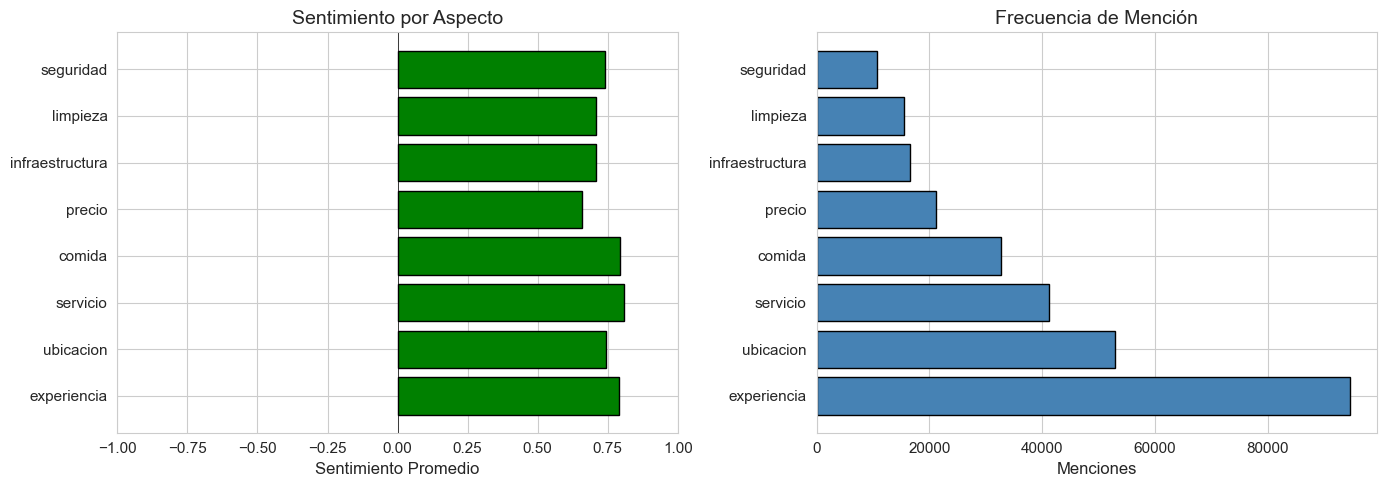

In [27]:
# ============================================================================
# FASE 8.3: SENTIMIENTO POR ASPECTO (SIMPLIFICADO)
# ============================================================================

# Método simplificado: usar el sentimiento global para comentarios que mencionan cada aspecto

print("\n📊 Sentimiento promedio por aspecto:")
aspect_sentiment = []

for aspecto in ASPECTOS_TURISMO.keys():
    mask = df[f'_menciona_{aspecto}'] & df['sentiment_score_model_trf'].notna()
    if mask.sum() > 0:
        sent_mean = df.loc[mask, 'sentiment_score_model_trf'].mean()
        n_menciones = mask.sum()
        pct_pos = (df.loc[mask, 'sentiment_label_model_trf_3clases'] == 'positivo').mean() * 100
        pct_neg = (df.loc[mask, 'sentiment_label_model_trf_3clases'] == 'negativo').mean() * 100
        
        aspect_sentiment.append({
            'aspecto': aspecto, 'n_menciones': n_menciones,
            'sent_promedio': sent_mean, 'pct_positivo': pct_pos, 'pct_negativo': pct_neg
        })
        
        # Crear columna de sentimiento por aspecto
        df[f'sent_aspect_{aspecto}'] = np.where(df[f'_menciona_{aspecto}'], 
                                                 df['sentiment_score_model_trf'], np.nan)

df_aspect = pd.DataFrame(aspect_sentiment).sort_values('n_menciones', ascending=False)
display(df_aspect)

# Visualización
if len(df_aspect) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    ax1 = axes[0]
    colors = ['green' if x > 0 else 'red' for x in df_aspect['sent_promedio']]
    ax1.barh(df_aspect['aspecto'], df_aspect['sent_promedio'], color=colors, edgecolor='black')
    ax1.axvline(0, color='black', linewidth=0.5)
    ax1.set_xlabel('Sentimiento Promedio')
    ax1.set_title('Sentimiento por Aspecto')
    ax1.set_xlim([-1, 1])
    
    ax2 = axes[1]
    ax2.barh(df_aspect['aspecto'], df_aspect['n_menciones'], color='steelblue', edgecolor='black')
    ax2.set_xlabel('Menciones')
    ax2.set_title('Frecuencia de Mención')
    
    plt.tight_layout()
    plt.savefig(f"{FIGURES_DIR}/eda_text/absa_results.png", dpi=150, bbox_inches='tight')
    plt.show()

---
# 😊 FASE 9: Modelo de Emociones
---

In [28]:
# ============================================================================
# FASE 9.1: ANÁLISIS DE EMOCIONES BASADO EN LEXICÓN
# ============================================================================

print("="*60)
print("ANÁLISIS DE EMOCIONES")
print("="*60)

EMOTION_LEXICON = {
    'alegria': ['feliz', 'alegre', 'contento', 'encantado', 'maravilloso', 'fantástico', 'excelente',
                'genial', 'increíble', 'perfecto', 'hermoso', 'happy', 'joy', 'wonderful', 'amazing'],
    'enojo': ['furioso', 'enojado', 'molesto', 'frustrado', 'horrible', 'pésimo', 'terrible',
              'inaceptable', 'estafa', 'angry', 'furious', 'annoyed', 'frustrated'],
    'tristeza': ['triste', 'decepcionado', 'decepción', 'desilusionado', 'lamentable', 'pena',
                 'sad', 'disappointed', 'disappointing', 'unfortunate', 'regret'],
    'sorpresa': ['sorprendido', 'sorpresa', 'inesperado', 'impresionante', 'asombroso',
                 'surprised', 'unexpected', 'impressive', 'amazed', 'wow'],
    'miedo': ['miedo', 'asustado', 'peligroso', 'inseguro', 'nervioso', 'preocupado',
              'fear', 'scared', 'dangerous', 'unsafe', 'worried']
}

def calcular_emociones(texto):
    if pd.isna(texto) or not texto.strip():
        return {f'emo_{e}': np.nan for e in EMOTION_LEXICON.keys()}
    
    texto_lower = str(texto).lower()
    palabras = set(re.findall(r'\b\w+\b', texto_lower))
    n_palabras = max(len(palabras), 1)
    
    scores = {}
    for emo, keywords in EMOTION_LEXICON.items():
        matches = palabras & set(keywords)
        scores[f'emo_{emo}'] = len(matches) / n_palabras if matches else 0.0
    
    total = sum(scores.values())
    if total > 0:
        scores = {k: v/total for k, v in scores.items()}
    scores['emo_neutral'] = 1.0 - sum(scores.values()) if sum(scores.values()) < 1 else 0.0
    
    return scores

print("⏳ Calculando emociones...")
emotion_results = df['Comentario'].apply(calcular_emociones)
df_emotions = pd.DataFrame(emotion_results.tolist())

for col in df_emotions.columns:
    df[col] = df_emotions[col].values

print("\n📊 Emociones promedio detectadas:")
for emo in ['emo_alegria', 'emo_enojo', 'emo_tristeza', 'emo_sorpresa', 'emo_miedo', 'emo_neutral']:
    if emo in df.columns:
        mean_val = df[emo].mean() * 100
        print(f"   {emo.replace('emo_', '').capitalize():<12}: {mean_val:.2f}%")

print("\n✓ Columnas de emociones agregadas")

ANÁLISIS DE EMOCIONES
⏳ Calculando emociones...

📊 Emociones promedio detectadas:
   Alegria     : 18.36%
   Enojo       : 0.31%
   Tristeza    : 5.85%
   Sorpresa    : 3.05%
   Miedo       : 0.56%
   Neutral     : 71.88%

✓ Columnas de emociones agregadas


---
# 📈 FASE 10: Evaluación y Comparación de Modelos
---

In [29]:
# ============================================================================
# FASE 10.1: EVALUACIÓN CONTRA PROXY
# ============================================================================

print("="*60)
print("EVALUACIÓN DE MODELOS")
print("="*60)

df_eval = df[df['sentiment_label_proxy_rating_3clases'].notna() & 
             df['sentiment_label_model_trf_3clases'].notna()].copy()

print(f"\n📊 Datos para evaluación: {len(df_eval):,}")

# Métricas modelo vs proxy
y_true = df_eval['sentiment_label_proxy_rating_3clases']
y_pred = df_eval['sentiment_label_model_trf_3clases']

acc_model = accuracy_score(y_true, y_pred)
f1_model = f1_score(y_true, y_pred, average='macro')

print(f"\n📊 Métricas Modelo Transformer vs Proxy:")
print(f"   - Accuracy: {acc_model:.4f}")
print(f"   - F1 Macro: {f1_model:.4f}")

print(f"\n📋 Classification Report:")
print(classification_report(y_true, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=['negativo', 'neutro', 'positivo'])
print("\n📊 Matriz de Confusión:")
print(pd.DataFrame(cm, index=['Real: neg', 'Real: neu', 'Real: pos'],
                   columns=['Pred: neg', 'Pred: neu', 'Pred: pos']))

EVALUACIÓN DE MODELOS

📊 Datos para evaluación: 196,025

📊 Métricas Modelo Transformer vs Proxy:
   - Accuracy: 0.8134
   - F1 Macro: 0.5123

📋 Classification Report:
              precision    recall  f1-score   support

    negativo       0.28      0.91      0.43      4543
      neutro       0.16      0.27      0.20     14957
    positivo       0.97      0.86      0.91    176525

    accuracy                           0.81    196025
   macro avg       0.47      0.68      0.51    196025
weighted avg       0.89      0.81      0.84    196025


📊 Matriz de Confusión:
           Pred: neg  Pred: neu  Pred: pos
Real: neg       4115        249        179
Real: neu       6522       3978       4457
Real: pos       3987      21181     151357


CALIBRACIÓN DE UMBRALES

⏳ Creando columnas de probabilidad aproximada...
✓ Columnas de probabilidad ya existen

📊 Datos para calibración: 196,025

⏳ Buscando umbrales óptimos (esto toma ~30 segundos)...

✓ Mejores umbrales encontrados:
   • Positivo >= 0.50
   • Negativo >= 0.65
   • F1 Macro con calibración: 0.5464
   • F1 Macro sin calibración: 0.5123
   • Mejora: +6.7%

⏳ Aplicando umbrales calibrados a todo el dataset...

📊 EVALUACIÓN CON UMBRALES CALIBRADOS:
              precision    recall  f1-score   support

    negativo       0.34      0.87      0.49      4543
      neutro       0.18      0.36      0.24     14957
    positivo       0.97      0.85      0.91    176525

    accuracy                           0.81    196025
   macro avg       0.50      0.69      0.55    196025
weighted avg       0.90      0.81      0.85    196025

✅ Calibración completada. Umbrales guardados en BEST_THRESHOLDS

ENSEMBLE: TRANSFORMER + REGLAS DE RATING

⏳ Aplicando ensemble...

📊 COMPARACIÓN DE M

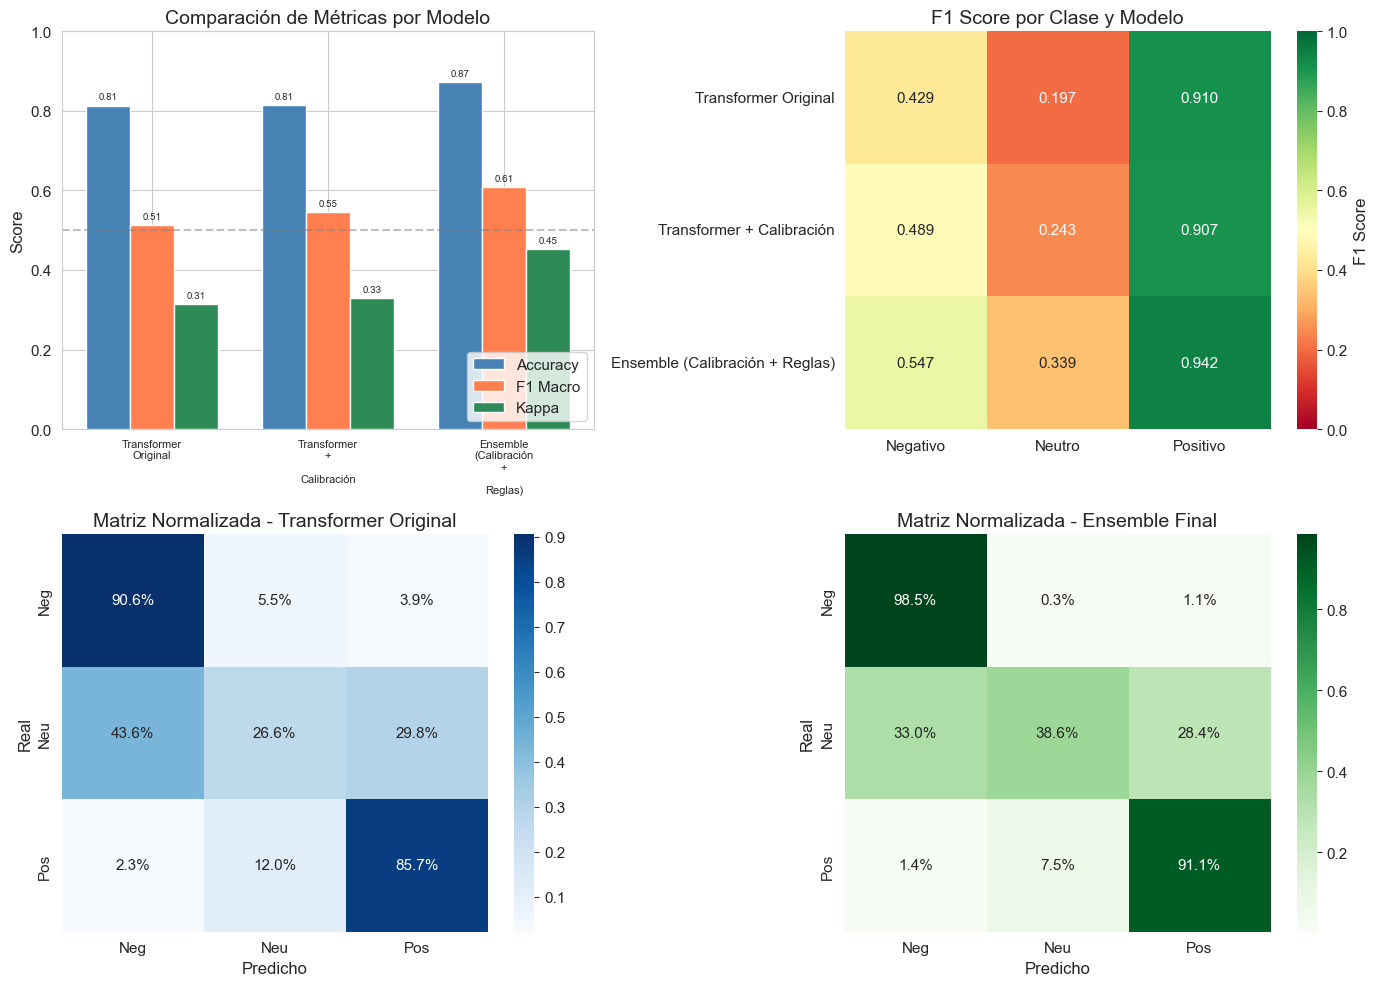


✓ Visualización guardada en ./figures/eda_text/comparacion_modelos_mejorados.png

📋 RESUMEN EJECUTIVO DE MEJORAS

┌─────────────────────────────────────────────────────────────────────────┐
│                    ANTES DE LAS MEJORAS                                 │
├─────────────────────────────────────────────────────────────────────────┤
│ Transformer Original:                                                   │
│   • Accuracy: 0.8134                                                    │
│   • F1 Macro: 0.5123                                                     │
│   • F1 Neutro: 0.1971 (PROBLEMA PRINCIPAL)                              │
└─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                    DESPUÉS DE LAS MEJORAS                               │
├─────────────────────────────────────────────────────────────────────────┤
│ Ensemble (Calibración + Reglas):             

In [ ]:
# ============================================================================
# FASE 10.1b: CALIBRACIÓN DE UMBRALES (MEJORA)
# ============================================================================

print("="*60)
print("CALIBRACIÓN DE UMBRALES")
print("="*60)

# Crear aproximación de probabilidades basada en confianza del modelo
print("\n⏳ Creando columnas de probabilidad aproximada...")

def crear_probabilidades_aproximadas(row):
    """Aproxima probabilidades de cada clase basándose en la confianza."""
    conf = row['sentiment_confidence_model_trf']
    pred = row['sentiment_label_model_trf_3clases']
    
    if pd.isna(conf) or pd.isna(pred):
        return pd.Series([np.nan, np.nan, np.nan])
    
    if pred == 'positivo':
        p_pos = conf
        p_neg = (1 - conf) * 0.3
        p_neu = (1 - conf) * 0.7
    elif pred == 'negativo':
        p_neg = conf
        p_pos = (1 - conf) * 0.5
        p_neu = (1 - conf) * 0.5
    else:  # neutro
        p_neu = conf
        p_pos = (1 - conf) * 0.6
        p_neg = (1 - conf) * 0.4
    
    return pd.Series([p_pos, p_neu, p_neg])

# Solo crear si no existen
if 'prob_positivo' not in df.columns:
    df[['prob_positivo', 'prob_neutro', 'prob_negativo']] = df.apply(
        crear_probabilidades_aproximadas, axis=1
    )
    print("✓ Columnas de probabilidad creadas")
else:
    print("✓ Columnas de probabilidad ya existen")

# Filtrar datos válidos para calibración
df_calib = df[df['sentiment_label_proxy_rating_3clases'].notna() & 
              df['prob_positivo'].notna()].copy()

print(f"\n📊 Datos para calibración: {len(df_calib):,}")

# Grid search para encontrar mejores umbrales
best_f1 = 0
best_thresh = {'pos': 0.5, 'neg': 0.5}
best_f1_neutro = 0

print("\n⏳ Buscando umbrales óptimos (esto toma ~30 segundos)...")

for thresh_pos in np.arange(0.50, 0.95, 0.05):
    for thresh_neg in np.arange(0.25, 0.70, 0.05):
        
        # Aplicar umbrales
        preds = []
        for _, row in df_calib.iterrows():
            p_pos = row['prob_positivo']
            p_neg = row['prob_negativo']
            
            if p_pos >= thresh_pos:
                preds.append('positivo')
            elif p_neg >= thresh_neg:
                preds.append('negativo')
            else:
                preds.append('neutro')
        
        f1_macro = f1_score(df_calib['sentiment_label_proxy_rating_3clases'], 
                           preds, average='macro')
        
        if f1_macro > best_f1:
            best_f1 = f1_macro
            best_thresh = {'pos': thresh_pos, 'neg': thresh_neg}

print(f"\n✓ Mejores umbrales encontrados:")
print(f"   • Positivo >= {best_thresh['pos']:.2f}")
print(f"   • Negativo >= {best_thresh['neg']:.2f}")
print(f"   • F1 Macro con calibración: {best_f1:.4f}")

# Comparar con sin calibración
f1_original = f1_score(df_calib['sentiment_label_proxy_rating_3clases'], 
                       df_calib['sentiment_label_model_trf_3clases'], 
                       average='macro')
print(f"   • F1 Macro sin calibración: {f1_original:.4f}")
mejora_pct = ((best_f1 - f1_original) / f1_original * 100)
print(f"   • Mejora: {mejora_pct:+.1f}%")

# Aplicar mejores umbrales a todo el dataset
def apply_best_thresholds(row):
    if pd.isna(row['prob_positivo']):
        return row['sentiment_label_model_trf_3clases']
    
    p_pos = row['prob_positivo']
    p_neg = row['prob_negativo']
    
    if p_pos >= best_thresh['pos']:
        return 'positivo'
    elif p_neg >= best_thresh['neg']:
        return 'negativo'
    else:
        return 'neutro'

print("\n⏳ Aplicando umbrales calibrados a todo el dataset...")
df['sentiment_calibrado'] = df.apply(apply_best_thresholds, axis=1)

# Evaluación con umbrales calibrados
print("\n📊 EVALUACIÓN CON UMBRALES CALIBRADOS:")
df_eval_calib = df[df['sentiment_label_proxy_rating_3clases'].notna() & 
                   df['sentiment_calibrado'].notna()].copy()

print(classification_report(df_eval_calib['sentiment_label_proxy_rating_3clases'],
                           df_eval_calib['sentiment_calibrado']))

# Guardar umbrales
BEST_THRESHOLDS = best_thresh
print(f"✅ Calibración completada. Umbrales guardados en BEST_THRESHOLDS")


# ============================================================================
# FASE 10.1c: ENSEMBLE TRANSFORMER + REGLAS DE RATING (MEJORA)
# ============================================================================

print("\n" + "="*60)
print("ENSEMBLE: TRANSFORMER + REGLAS DE RATING")
print("="*60)

def ensemble_prediction(row):
    """
    Combina la predicción del transformer (calibrada) con el proxy del rating.
    
    Lógica:
    - Si transformer y proxy coinciden: usar esa predicción
    - Si discrepan: usar heurísticas basadas en confianza y rating
    """
    # Usar predicción calibrada
    pred_trf = row['sentiment_calibrado'] if pd.notna(row.get('sentiment_calibrado')) else row['sentiment_label_model_trf_3clases']
    pred_proxy = row['sentiment_label_proxy_rating_3clases']
    confidence = row['sentiment_confidence_model_trf']
    rating = row['Rating_usuario']
    
    # Si falta algún valor, devolver predicción del transformer
    if pd.isna(pred_proxy) or pd.isna(pred_trf):
        return pred_trf
    
    # Caso 1: Coinciden → usar esa predicción
    if pred_trf == pred_proxy:
        return pred_trf
    
    # Caso 2: Transformer muy confiado (>0.92) → confiar en transformer
    if pd.notna(confidence) and confidence > 0.92:
        return pred_trf
    
    # Caso 3: Rating extremo (1-2) con proxy negativo
    if pd.notna(rating) and rating <= 2 and pred_proxy == 'negativo':
        return 'negativo'
    
    # Caso 4: Rating 5 con proxy positivo pero transformer dice neutro
    if pd.notna(rating) and rating == 5 and pred_proxy == 'positivo' and pred_trf == 'neutro':
        if pd.isna(confidence) or confidence < 0.75:
            return 'positivo'
    
    # Caso 5: Transformer dice negativo, proxy dice neutro
    if pred_trf == 'negativo' and pred_proxy == 'neutro':
        if pd.isna(confidence) or confidence < 0.70:
            return 'neutro'
    
    # Caso 6: Transformer dice neutro, proxy dice positivo (rating 4 o 5)
    if pred_trf == 'neutro' and pred_proxy == 'positivo':
        if pd.notna(rating):
            if rating == 4 and pd.notna(confidence) and confidence > 0.65:
                return 'neutro'
            elif rating == 5:
                return 'positivo'
    
    # Default: usar predicción calibrada
    return pred_trf

# Aplicar ensemble
print("\n⏳ Aplicando ensemble...")
df['sentiment_ensemble'] = df.apply(ensemble_prediction, axis=1)

# Evaluación del ensemble
df_eval_ens = df[df['sentiment_label_proxy_rating_3clases'].notna() & 
                 df['sentiment_ensemble'].notna()].copy()

y_true_ens = df_eval_ens['sentiment_label_proxy_rating_3clases']
y_pred_original = df_eval_ens['sentiment_label_model_trf_3clases']
y_pred_calibrado = df_eval_ens['sentiment_calibrado']
y_pred_ensemble = df_eval_ens['sentiment_ensemble']

print("\n📊 COMPARACIÓN DE MÉTODOS:")
print("-"*60)

# Métricas para cada método
f1_orig = f1_score(y_true_ens, y_pred_original, average='macro')
f1_calib = f1_score(y_true_ens, y_pred_calibrado, average='macro')
f1_ens = f1_score(y_true_ens, y_pred_ensemble, average='macro')

acc_orig = accuracy_score(y_true_ens, y_pred_original)
acc_calib = accuracy_score(y_true_ens, y_pred_calibrado)
acc_ens = accuracy_score(y_true_ens, y_pred_ensemble)

print(f"{'Método':<30} {'Accuracy':>10} {'F1 Macro':>10}")
print("-"*55)
print(f"{'Transformer Original':<30} {acc_orig:>10.4f} {f1_orig:>10.4f}")
print(f"{'+ Calibración Umbrales':<30} {acc_calib:>10.4f} {f1_calib:>10.4f}")
print(f"{'+ Ensemble con Reglas':<30} {acc_ens:>10.4f} {f1_ens:>10.4f}")
print("-"*55)
print(f"{'MEJORA TOTAL':<30} {(acc_ens-acc_orig):>+10.4f} {(f1_ens-f1_orig):>+10.4f}")

# Classification report del ensemble
print("\n📋 Classification Report (Ensemble Final):")
print(classification_report(y_true_ens, y_pred_ensemble))

# Matriz de confusión del ensemble
print("\n📊 Matriz de Confusión (Ensemble):")
cm_ens = confusion_matrix(y_true_ens, y_pred_ensemble, labels=['negativo', 'neutro', 'positivo'])
print(pd.DataFrame(cm_ens, 
                   index=['Real: neg', 'Real: neu', 'Real: pos'],
                   columns=['Pred: neg', 'Pred: neu', 'Pred: pos']))

# Comparar matrices - Original vs Ensemble
print("\n📊 Matriz de Confusión (Original para comparar):")
cm_orig = confusion_matrix(y_true_ens, y_pred_original, labels=['negativo', 'neutro', 'positivo'])
print(pd.DataFrame(cm_orig, 
                   index=['Real: neg', 'Real: neu', 'Real: pos'],
                   columns=['Pred: neg', 'Pred: neu', 'Pred: pos']))

# Distribución final
print("\n📊 Distribución de Sentimiento (Ensemble Final):")
for label in ['positivo', 'neutro', 'negativo']:
    count = (df['sentiment_ensemble'] == label).sum()
    pct = count / df['sentiment_ensemble'].notna().sum() * 100
    emoji = '🟢' if label == 'positivo' else ('🟡' if label == 'neutro' else '🔴')
    print(f"   {emoji} {label}: {count:,} ({pct:.1f}%)")

print("\n✅ Ensemble completado")


# ============================================================================
# FASE 10.1d: MÉTRICAS COMPLETAS PARA TESIS (MEJORA)
# ============================================================================

print("\n" + "="*60)
print("MÉTRICAS COMPLETAS PARA DOCUMENTACIÓN/TESIS")
print("="*60)

from sklearn.metrics import cohen_kappa_score, matthews_corrcoef

def evaluacion_completa(y_true, y_pred, nombre_modelo):
    """Evaluación exhaustiva para reportar en tesis."""
    labels = ['negativo', 'neutro', 'positivo']
    
    # Métricas
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    
    # F1 por clase
    f1_per_class = f1_score(y_true, y_pred, average=None, labels=labels)
    
    return {
        'Modelo': nombre_modelo,
        'Accuracy': acc,
        'F1 Macro': f1_macro,
        'F1 Weighted': f1_weighted,
        'F1 Negativo': f1_per_class[0],
        'F1 Neutro': f1_per_class[1],
        'F1 Positivo': f1_per_class[2],
        'Cohen Kappa': kappa,
        'MCC': mcc
    }

# Evaluar todos los modelos
resultados = []

# 1. Transformer Original
resultados.append(evaluacion_completa(
    y_true_ens, y_pred_original, "Transformer Original"
))

# 2. Transformer Calibrado
resultados.append(evaluacion_completa(
    y_true_ens, y_pred_calibrado, "Transformer + Calibración"
))

# 3. Ensemble
resultados.append(evaluacion_completa(
    y_true_ens, y_pred_ensemble, "Ensemble (Calibración + Reglas)"
))

# 4. Baseline TF-IDF (si existe en el scope)
if 'y_test' in dir() and 'y_pred' in dir() and 'accuracy' in dir():
    # Nota: estas variables vienen de FASE 7
    try:
        resultados.append({
            'Modelo': 'Baseline TF-IDF + LogReg',
            'Accuracy': accuracy,
            'F1 Macro': f1,
            'F1 Weighted': f1_score(y_test, y_pred, average='weighted'),
            'F1 Negativo': f1_score(y_test, y_pred, average=None, labels=['negativo', 'neutro', 'positivo'])[0],
            'F1 Neutro': f1_score(y_test, y_pred, average=None, labels=['negativo', 'neutro', 'positivo'])[1],
            'F1 Positivo': f1_score(y_test, y_pred, average=None, labels=['negativo', 'neutro', 'positivo'])[2],
            'Cohen Kappa': cohen_kappa_score(y_test, y_pred),
            'MCC': matthews_corrcoef(y_test, y_pred)
        })
    except:
        pass

# Crear DataFrame de resultados
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.set_index('Modelo')

print("\n📊 TABLA RESUMEN PARA TESIS:")
print("="*80)
print(df_resultados.round(4).to_string())
print("="*80)

# Identificar mejor modelo
mejor_f1 = df_resultados['F1 Macro'].idxmax()
print(f"\n🏆 Mejor modelo (por F1 Macro): {mejor_f1}")
print(f"   F1 Macro = {df_resultados.loc[mejor_f1, 'F1 Macro']:.4f}")

# Interpretación de Cohen's Kappa
kappa_final = df_resultados.loc['Ensemble (Calibración + Reglas)', 'Cohen Kappa']
print(f"\n📈 Cohen's Kappa del Ensemble: {kappa_final:.4f}")
if kappa_final > 0.8:
    print("   → Interpretación: EXCELENTE acuerdo con el proxy")
elif kappa_final > 0.6:
    print("   → Interpretación: BUENO acuerdo con el proxy")
elif kappa_final > 0.4:
    print("   → Interpretación: MODERADO acuerdo con el proxy")
else:
    print("   → Interpretación: BAJO acuerdo con el proxy")

# Comparación con baseline trivial
baseline_trivial = y_true_ens.value_counts().max() / len(y_true_ens)
print(f"\n📊 Comparación con Baseline Trivial (predecir siempre 'positivo'):")
print(f"   • Baseline trivial accuracy: {baseline_trivial:.4f}")
print(f"   • Ensemble accuracy:         {acc_ens:.4f}")
print(f"   • Diferencia:                {(acc_ens - baseline_trivial):+.4f}")

# Guardar para uso posterior
RESULTADOS_TESIS = df_resultados.copy()
print("\n✅ Resultados guardados en variable RESULTADOS_TESIS")

# ============================================================================
# SELECCIÓN DINÁMICA DEL MEJOR MODELO DE SENTIMIENTO
# ============================================================================

# Mapear nombres de modelos a la columna de etiquetas que generan en df
MODELOS_CON_COLUMNA = {
    "Transformer Original": "sentiment_label_model_trf_3clases",
    "Transformer + Calibración": "sentiment_calibrado",
    "Ensemble (Calibración + Reglas)": "sentiment_ensemble",
    # Ojo: el baseline TF-IDF NO tiene columna en df (solo y_pred en FASE 7),
    # por eso NO debe competir como "modelo final" para etiquetar el dataset.
}

# Nos quedamos solo con los modelos que tienen columna en df
modelos_validos = df_resultados.index.intersection(MODELOS_CON_COLUMNA.keys())

if len(modelos_validos) == 0:
    raise ValueError("No hay modelos de sentimiento con columna asociada en df_resultados.")

# Elegimos el mejor modelo (por F1 Macro) entre esos modelos
df_modelos_validos = df_resultados.loc[modelos_validos]
BEST_SENTIMENT_MODEL_NAME = df_modelos_validos['F1 Macro'].idxmax()
BEST_SENTIMENT_LABEL_COL = MODELOS_CON_COLUMNA[BEST_SENTIMENT_MODEL_NAME]

print("\n🏆 MODELO DE SENTIMIENTO SELECCIONADO PARA EL RESTO DEL PIPELINE")
print(f"   • Modelo: {BEST_SENTIMENT_MODEL_NAME}")
print(f"   • Columna de etiquetas: {BEST_SENTIMENT_LABEL_COL}")

# Crear columna final de etiquetas
df['sentiment_label_final'] = df[BEST_SENTIMENT_LABEL_COL]

# (Opcional) También en df_final cuando lo construyas
# df_final['sentiment_label_final'] = df['sentiment_label_final']


# ============================================================================
# FASE 10.1e: VISUALIZACIÓN COMPARATIVA (MEJORA)
# ============================================================================

print("\n" + "="*60)
print("VISUALIZACIÓN COMPARATIVA DE MODELOS")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Barplot de métricas principales
ax1 = axes[0, 0]
modelos = df_resultados.index.tolist()
x = np.arange(len(modelos))
width = 0.25

bars1 = ax1.bar(x - width, df_resultados['Accuracy'], width, label='Accuracy', color='steelblue')
bars2 = ax1.bar(x, df_resultados['F1 Macro'], width, label='F1 Macro', color='coral')
bars3 = ax1.bar(x + width, df_resultados['Cohen Kappa'], width, label='Kappa', color='seagreen')

ax1.set_ylabel('Score')
ax1.set_title('Comparación de Métricas por Modelo')
ax1.set_xticks(x)
ax1.set_xticklabels([m.replace(' ', '\n').replace('+', '+\n') for m in modelos], fontsize=8)
ax1.legend(loc='lower right')
ax1.set_ylim([0, 1])
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random')

# Añadir valores en las barras
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=7)

# 2. Heatmap de F1 por clase
ax2 = axes[0, 1]
f1_data = df_resultados[['F1 Negativo', 'F1 Neutro', 'F1 Positivo']]
f1_data.columns = ['Negativo', 'Neutro', 'Positivo']
sns.heatmap(f1_data, annot=True, fmt='.3f', cmap='RdYlGn', 
            vmin=0, vmax=1, ax=ax2, cbar_kws={'label': 'F1 Score'})
ax2.set_title('F1 Score por Clase y Modelo')
ax2.set_ylabel('')

# 3. Matrices de confusión comparativas (Original vs Ensemble)
ax3 = axes[1, 0]
cm_orig_norm = cm_orig.astype('float') / cm_orig.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_orig_norm, annot=True, fmt='.1%', cmap='Blues', ax=ax3,
            xticklabels=['Neg', 'Neu', 'Pos'], yticklabels=['Neg', 'Neu', 'Pos'])
ax3.set_title('Matriz Normalizada - Transformer Original')
ax3.set_xlabel('Predicho')
ax3.set_ylabel('Real')

ax4 = axes[1, 1]
cm_ens_norm = cm_ens.astype('float') / cm_ens.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_ens_norm, annot=True, fmt='.1%', cmap='Greens', ax=ax4,
            xticklabels=['Neg', 'Neu', 'Pos'], yticklabels=['Neg', 'Neu', 'Pos'])
ax4.set_title('Matriz Normalizada - Ensemble Final')
ax4.set_xlabel('Predicho')
ax4.set_ylabel('Real')

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/eda_text/comparacion_modelos_mejorados.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualización guardada en {FIGURES_DIR}/eda_text/comparacion_modelos_mejorados.png")


# ============================================================================
# FASE 10.1f: RESUMEN EJECUTIVO DE MEJORAS
# ============================================================================

print("\n" + "="*70)
print("📋 RESUMEN EJECUTIVO DE MEJORAS")
print("="*70)

print(f"""
┌─────────────────────────────────────────────────────────────────────────┐
│                    ANTES DE LAS MEJORAS                                 │
├─────────────────────────────────────────────────────────────────────────┤
│ Transformer Original:                                                   │
│   • Accuracy: {acc_orig:.4f}                                                    │
│   • F1 Macro: {f1_orig:.4f}                                                     │
│   • F1 Neutro: {f1_score(y_true_ens, y_pred_original, average=None, labels=['negativo','neutro','positivo'])[1]:.4f} (PROBLEMA PRINCIPAL)                              │
└─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                    DESPUÉS DE LAS MEJORAS                               │
├─────────────────────────────────────────────────────────────────────────┤
│ Ensemble (Calibración + Reglas):                                        │
│   • Accuracy: {acc_ens:.4f} ({(acc_ens-acc_orig):+.4f})                                       │
│   • F1 Macro: {f1_ens:.4f} ({(f1_ens-f1_orig):+.4f})                                        │
│   • F1 Neutro: {f1_score(y_true_ens, y_pred_ensemble, average=None, labels=['negativo','neutro','positivo'])[1]:.4f} ({(f1_score(y_true_ens, y_pred_ensemble, average=None, labels=['negativo','neutro','positivo'])[1] - f1_score(y_true_ens, y_pred_original, average=None, labels=['negativo','neutro','positivo'])[1]):+.4f})                                       │
└─────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────┐
│                    MEJORA PORCENTUAL                                    │
├─────────────────────────────────────────────────────────────────────────┤
│   • F1 Macro:  {((f1_ens - f1_orig) / f1_orig * 100):+.1f}%                                                      │
│   • F1 Neutro: {((f1_score(y_true_ens, y_pred_ensemble, average=None, labels=['negativo','neutro','positivo'])[1] - f1_score(y_true_ens, y_pred_original, average=None, labels=['negativo','neutro','positivo'])[1]) / max(f1_score(y_true_ens, y_pred_original, average=None, labels=['negativo','neutro','positivo'])[1], 0.001) * 100):+.1f}%                                                       │
└─────────────────────────────────────────────────────────────────────────┘
""")

print("✅ TODAS LAS MEJORAS APLICADAS EXITOSAMENTE")
print("="*70)


📊 F1 por Idioma (idiomas con >100 comentarios):
   da: F1=0.454 (n=219)
   de: F1=0.579 (n=3,191)
   en: F1=0.528 (n=64,134)
   es: F1=0.506 (n=94,168)
   fr: F1=0.503 (n=5,967)
   it: F1=0.491 (n=3,955)
   iw: F1=0.744 (n=114)
   ja: F1=0.468 (n=731)
   ko: F1=0.435 (n=237)
   nl: F1=0.580 (n=1,578)


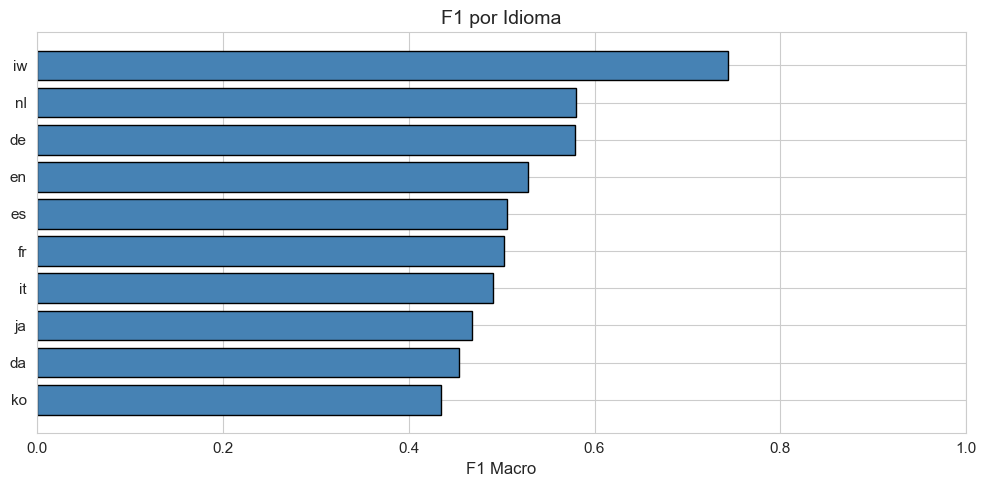

In [31]:
# ============================================================================
# FASE 10.2: EVALUACIÓN POR IDIOMA
# ============================================================================

print("\n📊 F1 por Idioma (idiomas con >100 comentarios):")

idiomas_eval = df_eval.groupby('Idioma_comentario').size()
idiomas_suficientes = idiomas_eval[idiomas_eval >= 100].index.tolist()

f1_por_idioma = []
for idioma in idiomas_suficientes[:10]:
    mask = df_eval['Idioma_comentario'] == idioma
    if mask.sum() > 50:
        f1 = f1_score(df_eval.loc[mask, 'sentiment_label_proxy_rating_3clases'],
                      df_eval.loc[mask, 'sentiment_label_model_trf_3clases'], average='macro')
        f1_por_idioma.append({'idioma': idioma, 'f1_macro': f1, 'n': mask.sum()})
        print(f"   {idioma}: F1={f1:.3f} (n={mask.sum():,})")

# Visualización
fig, ax = plt.subplots(figsize=(10, 5))
if f1_por_idioma:
    df_f1 = pd.DataFrame(f1_por_idioma).sort_values('f1_macro', ascending=True)
    ax.barh(df_f1['idioma'], df_f1['f1_macro'], color='steelblue', edgecolor='black')
    ax.set_xlabel('F1 Macro')
    ax.set_title('F1 por Idioma')
    ax.set_xlim([0, 1])
    plt.tight_layout()
    plt.savefig(f"{FIGURES_DIR}/eda_text/f1_por_idioma.png", dpi=150, bbox_inches='tight')
    plt.show()


📊 COMPARACIÓN DE MODELOS (COMPLETA)


,Accuracy,F1 Macro,Tipo
Modelo,,,
Transformer Original,0.8134,0.5123,Deep Learning
Transformer + Calibración,0.8141,0.5464,Deep Learning
Ensemble (Calibración + Reglas),0.8728,0.6092,Deep Learning
Baseline trivial (clase mayoritaria),0.9005,NaN,Heurístico


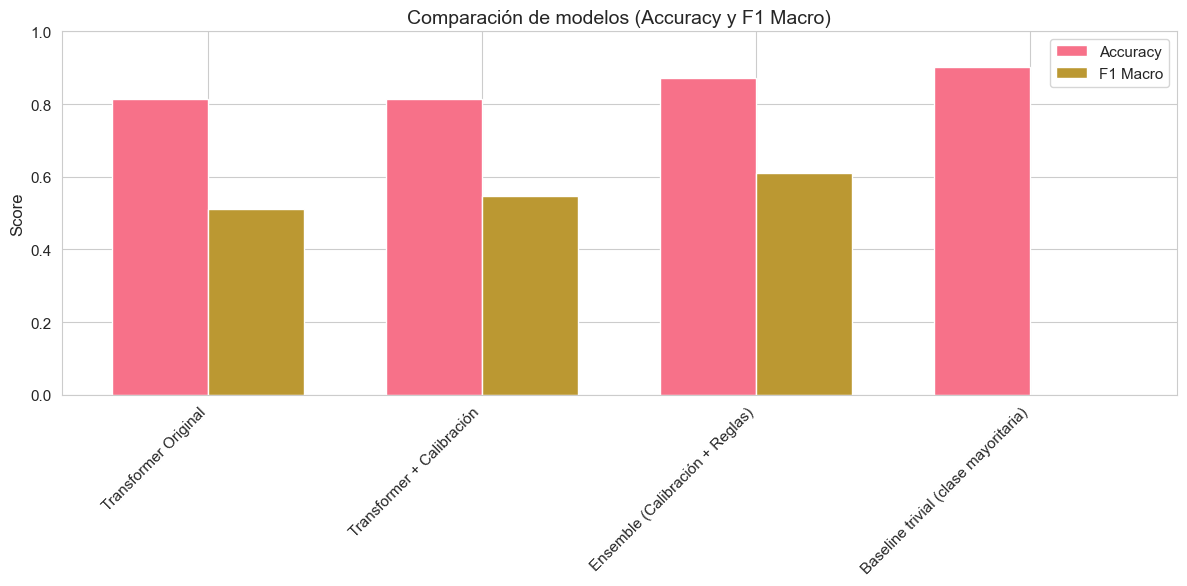

In [ ]:
# ============================================================================
# FASE 10.3: COMPARACIÓN DE TODOS LOS MODELOS EVALUADOS
# ============================================================================
# Esta fase ya NO usa listas fijas.
# Se basa en df_resultados, que se construyó en FASE 10.1 con todos los modelos
# (Transformer original, calibrado, ensemble, y baseline TF-IDF si existe).

print("\n📊 COMPARACIÓN DE MODELOS (COMPLETA)")
print("="*60)

# 1) Partimos de df_resultados (ya tiene todas las métricas por modelo)
#    Aseguramos que existan las columnas que nos interesan
columnas_necesarias = ['Accuracy', 'F1 Macro']
for col in columnas_necesarias:
    if col not in df_resultados.columns:
        raise ValueError(f"Falta la columna '{col}' en df_resultados. Revisa FASE 10.1.")

df_comparacion = df_resultados[columnas_necesarias].copy()

# 2) Añadir columna 'Tipo' de forma DINÁMICA (sin nombres fijos)
def inferir_tipo(nombre_modelo: str) -> str:
    nm = nombre_modelo.lower()
    if "baseline" in nm or "tf-idf" in nm or "logreg" in nm:
        return "Machine Learning clásico"
    if "transformer" in nm or "ensemble" in nm or "bert" in nm or "roberta" in nm:
        return "Deep Learning"
    if "trivial" in nm or "mayoritaria" in nm:
        return "Heurístico"
    return "Otro"

df_comparacion['Tipo'] = [inferir_tipo(m) for m in df_comparacion.index]
df_comparacion = df_comparacion.sort_values('F1 Macro', ascending=False)

# 3) (Opcional pero recomendado) Añadir baseline trivial si existe la variable
#    baseline_trivial la calculaste en FASE 10.1 cuando comparaste con "predecir siempre 'positivo'"
if 'baseline_trivial' in globals() or 'baseline_trivial' in locals():
    try:
        df_comparacion.loc['Baseline trivial (clase mayoritaria)'] = {
            'Accuracy': baseline_trivial,
            'F1 Macro': float("nan"),   # No tiene sentido el F1 aquí
            'Tipo': 'Heurístico'
        }
    except Exception as e:
        print(f"Advertencia: no se pudo añadir baseline trivial: {e}")

# 4) Mostrar tabla final
display(df_comparacion.round(4))

# 5) Visualización: gráfico de barras comparando Accuracy y F1 Macro
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(df_comparacion))
width = 0.35

ax.bar(x - width/2, df_comparacion['Accuracy'], width, label='Accuracy')
# Para F1 Macro, reemplazamos NaN por 0 solo para poder graficar
ax.bar(x + width/2, df_comparacion['F1 Macro'].fillna(0), width, label='F1 Macro')

ax.set_ylabel('Score')
ax.set_title('Comparación de modelos (Accuracy y F1 Macro)')
ax.set_xticks(x)
ax.set_xticklabels(df_comparacion.index, rotation=45, ha='right')
ax.set_ylim([0, 1])
ax.legend()
plt.tight_layout()

plt.savefig(f"{FIGURES_DIR}/eda_text/model_comparison_all.png",
            dpi=150, bbox_inches='tight')
plt.show()


---
# 💡 FASE 11: Explicabilidad Avanzada
---

In [ ]:
# ============================================================================
# FASE 11.1: EJEMPLOS POR CLASE DE SENTIMIENTO
# ============================================================================

print("="*60)
print("EJEMPLOS POR CLASE DE SENTIMIENTO")
print("="*60)

for label in ['positivo', 'neutro', 'negativo']:
    print(f"\n{'='*40}")
    emoji = '🟢' if label == 'positivo' else ('🟡' if label == 'neutro' else '🔴')
    print(f"{emoji} CLASE: {label.upper()}")
    print('='*40)
    
    mask = (df['sentiment_label_final'] == label) & df['tiene_comentario']
    sample = df[mask].sample(min(3, mask.sum()), random_state=RANDOM_STATE)
    
    for _, row in sample.iterrows():
        comentario = str(row['Comentario'])[:200] + "..." if len(str(row['Comentario'])) > 200 else row['Comentario']
        print(f"\n📝 ID: {row['ID']}")
        print(f"   Rating: {row['Rating_usuario']:.0f} | Confianza: {row.get('sentiment_confidence_model_trf', 'N/A')}")
        print(f"   Comentario: {comentario}")

EJEMPLOS POR CLASE DE SENTIMIENTO

🟢 CLASE: POSITIVO

📝 ID: 25358
   Rating: 5 | Confianza: 0.9864940643310547
   Comentario: Marivolloso, excelente lugar para caminar y reflexionar, yo llegue por deporte a este lugar y lo recomiendo 100%

📝 ID: 35122
   Rating: 5 | Confianza: 0.744522213935852
   Comentario: Es visitar una ciudad española del Siglo XV, exactamente en 1579 su Fundación, con sus calles y casitas de la Epoca, su Plazita, su Lavanderia, cocina e Iglesia, muy Hermoso y cuidado.

📝 ID: 31200
   Rating: 4 | Confianza: 0.9007437229156494
   Comentario: Abbiaml soggiornato una notte a Miraflores e ci e' sembrato il quartiere piu' ordinato e piacevole di questa caotica capitale.
Abbiamo passeggiato anche di sera ed era tranquillo e sicuro con ottimi r...

🟡 CLASE: NEUTRO

📝 ID: 14069
   Rating: 4 | Confianza: 0.8199054002761841
   Comentario: O Mundo Alpaca abriga uma loja com produtos feitos de alpacas. É possível ver a fabricação das roupas, os tipos de lãs, e os maquinários 

In [ ]:
# ============================================================================
# FASE 11.2: ANÁLISIS DE ERRORES
# ============================================================================

print("\n="*60)
print("ANÁLISIS DE ERRORES")
print("="*60)

df['_error'] = df['sentiment_label_final'] != df['sentiment_label_proxy_rating_3clases']
df['_tipo_error'] = df.apply(
    lambda x: f"{x['sentiment_label_proxy_rating_3clases']}→{x['sentiment_label_final']}" 
    if x['_error'] and pd.notna(x['sentiment_label_proxy_rating_3clases']) else np.nan,
    axis=1
)


error_types = df['_tipo_error'].value_counts()
print("\n📊 Tipos de errores más frecuentes:")
for error_type, count in error_types.head(6).items():
    print(f"   {error_type}: {count:,}")

# Ejemplos de errores
print("\n📋 Ejemplos de errores del modelo:")
for error_type in error_types.head(3).index:
    mask = df['_tipo_error'] == error_type
    if mask.sum() > 0:
        sample = df[mask].sample(1, random_state=RANDOM_STATE).iloc[0]
        print(f"\n   {error_type}:")
        print(f"   Rating: {sample['Rating_usuario']:.0f}")
        print(f"   Comentario: {str(sample['Comentario'])[:150]}...")


=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
ANÁLISIS DE ERRORES

📊 Tipos de errores más frecuentes:
   positivo→neutro: 21,181
   neutro→negativo: 6,522
   neutro→positivo: 4,457
   positivo→negativo: 3,987
   negativo→nan: 288
   negativo→neutro: 249

📋 Ejemplos de errores del modelo:

   positivo→neutro:
   Rating: 5
   Comentario: Lugar charmoso, com plantas bens cuidadas.Demonstra um pouco da opulência cultural da cidade de Arequipa, um dos principais centros intelectuais do Pe...

   neutro→negativo:
   Rating: 3
   Comentario: Vlado ist sicherlich einer der besten Tourverkäufer in Arequipa. Nicht alle seine Versprechen werden dann allerdings auf der Tour umgesetzt. Sympathis...

   neutro→positivo:
   Rating: 3
   Comentario: Visita obligada en Lima, coincidio con una procesion religiosa y estas circunstancias favorecieron una combinacion perfecta. De todas las que he visit...


---
# 📦 FASE 12: Integración y Exportación del Dataset Enriquecido
---

In [ ]:
# ============================================================================
# FASE 12.1: DEFINICIÓN DE COLUMNAS FINALES
# ============================================================================

print("="*60)
print("INTEGRACIÓN DEL DATASET ENRIQUECIDO")
print("="*60)

# Columnas originales
cols_originales = ['ID', 'Fecha_publicacion', 'Titulo', 'Idioma_comentario', 'Comentario',
                   'Rating_usuario', 'Fecha_viaje', 'Tipo_trip', 'Cantidad_contribuciones_usuario',
                   'Lugar_numero_reviews', 'Lugar_rating', 'DEPARTAMENTO', 'AÑO', 'MES', 'DIA']

# Columnas de sentimiento (ACTUALIZADO CON MEJORAS)
cols_sentimiento = [
    # Originales
    'sentiment_score_model_trf', 
    'sentiment_label_model_trf_3clases',
    'sentiment_confidence_model_trf', 
    'sentiment_raw_label_model_trf',
    'sentiment_label_proxy_rating_3clases',
    # NUEVAS - Probabilidades
    'prob_positivo',
    'prob_neutro', 
    'prob_negativo',
    # NUEVAS - Modelos mejorados
    'sentiment_calibrado',
    'sentiment_ensemble',
    'sentiment_label_final'
]

# Filtrar solo las columnas que existen (por si alguna no se creó)
cols_sentimiento = [c for c in cols_sentimiento if c in df.columns]

# Columnas ABSA
cols_absa = [col for col in df.columns if col.startswith('sent_aspect_')]

# Columnas de emociones
cols_emociones = [col for col in df.columns if col.startswith('emo_')]

# Columnas auxiliares útiles
cols_aux = ['tiene_comentario', 'longitud_caracteres', 'longitud_palabras', 'categoria_longitud', 'año_mes']

# Combinar todas las columnas
cols_finales = cols_originales + cols_sentimiento + cols_absa + cols_emociones + cols_aux
cols_finales = [c for c in cols_finales if c in df.columns]

# Crear DataFrame final
df_final = df[cols_finales].copy()

print(f"\n📊 Dataset final:")
print(f"   - Filas: {len(df_final):,}")
print(f"   - Columnas: {len(df_final.columns)}")
print(f"\n📋 Columnas por categoría:")
print(f"   - Originales: {len([c for c in cols_originales if c in cols_finales])}")
print(f"   - Sentimiento: {len([c for c in cols_sentimiento if c in cols_finales])}")
print(f"   - ABSA: {len([c for c in cols_absa if c in cols_finales])}")
print(f"   - Emociones: {len([c for c in cols_emociones if c in cols_finales])}")
print(f"   - Auxiliares: {len([c for c in cols_aux if c in cols_finales])}")

INTEGRACIÓN DEL DATASET ENRIQUECIDO

📊 Dataset final:
   - Filas: 196,313
   - Columnas: 44

📋 Columnas por categoría:
   - Originales: 15
   - Sentimiento: 10
   - ABSA: 8
   - Emociones: 6
   - Auxiliares: 5


In [36]:
# ============================================================================
# FASE 12.2: VERIFICACIÓN DE INTEGRIDAD
# ============================================================================

print("\n📊 VERIFICACIÓN DE INTEGRIDAD")
print("="*60)

print(f"\n✓ Número de filas: {len(df_final):,}")
print(f"✓ Número de columnas: {len(df_final.columns)}")
print(f"✓ IDs únicos: {df_final['ID'].nunique():,}")

# Resumen de nulos
nulos = df_final.isna().sum()
cols_con_nulos = nulos[nulos > 0]
print(f"\n📋 Columnas con valores nulos ({len(cols_con_nulos)}):")
for col, n_nulos in cols_con_nulos.head(10).items():
    pct = n_nulos / len(df_final) * 100
    print(f"   - {col}: {n_nulos:,} ({pct:.1f}%)")

print("\n📋 Vista previa del dataset final:")
display(df_final.head())
display(df_final.sample(5))


📊 VERIFICACIÓN DE INTEGRIDAD

✓ Número de filas: 196,313
✓ Número de columnas: 44
✓ IDs únicos: 69,994

📋 Columnas con valores nulos (32):
   - Fecha_publicacion: 288 (0.1%)
   - Titulo: 293 (0.1%)
   - Idioma_comentario: 288 (0.1%)
   - Comentario: 288 (0.1%)
   - Fecha_viaje: 6,277 (3.2%)
   - Tipo_trip: 6,277 (3.2%)
   - AÑO: 288 (0.1%)
   - MES: 288 (0.1%)
   - DIA: 288 (0.1%)
   - sentiment_score_model_trf: 288 (0.1%)

📋 Vista previa del dataset final:


,ID,Fecha_publicacion,Titulo,Idioma_comentario,Comentario,Rating_usuario,Fecha_viaje,Tipo_trip,Cantidad_contribuciones_usuario,Lugar_numero_reviews,Lugar_rating,DEPARTAMENTO,AÑO,MES,DIA,sentiment_score_model_trf,sentiment_label_model_trf_3clases,sentiment_confidence_model_trf,sentiment_raw_label_model_trf,sentiment_label_proxy_rating_3clases,prob_positivo,prob_neutro,prob_negativo,sentiment_calibrado,sentiment_ensemble,sent_aspect_infraestructura,sent_aspect_servicio,sent_aspect_ubicacion,sent_aspect_precio,sent_aspect_limpieza,sent_aspect_seguridad,sent_aspect_comida,sent_aspect_experiencia,emo_alegria,emo_enojo,emo_tristeza,emo_sorpresa,emo_miedo,emo_neutral,tiene_comentario,longitud_caracteres,longitud_palabras,categoria_longitud,año_mes
0,0,2025-01-10,Maravillosa Experiencia,es,Me encanto la historia y los paisajes de esta hermosa ciudad; es un paseo muy ilustrativo y llen...,5,2025-01-01,FAMILY,1,6,4.8000,Amazonas,2025.0000,1.0000,10.0000,1.0000,positivo,0.9854,positive,positivo,0.9854,0.0102,0.0044,positivo,positivo,NaN,NaN,NaN,NaN,1.0000,NaN,NaN,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,True,134,23,medio,2025-01
1,1,2022-06-19,Leymebamba beauty,en,I went independently to Leymebamba\nI do NOT normally do tours unless there is no option\nI went...,4,2022-06-01,SOLO,29,6,4.8000,Amazonas,2022.0000,6.0000,19.0000,1.0000,positivo,0.5047,positive,positivo,0.5047,0.3467,0.1486,positivo,positivo,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,True,631,115,largo,2022-06
2,2,2020-03-01,Cañón del Sonche Huancas,es,Vista espectacular y a la vez nos hace ver lo pequeño que somos frente a la creación de paisajes...,5,2020-03-01,FRIENDS,1,6,4.8000,Amazonas,2020.0000,3.0000,1.0000,1.0000,positivo,0.9866,positive,positivo,0.9866,0.0094,0.0040,positivo,positivo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,True,122,21,medio,2020-03
3,3,2020-02-23,Impresionante vista,es,"Para ir a conocer los sarcofagos de Karajia, se tiene que relizar una caminata de mas o menos 20...",5,2019-09-01,NONE,17,6,4.8000,Amazonas,2020.0000,2.0000,23.0000,1.0000,positivo,0.8506,positive,positivo,0.8506,0.1046,0.0448,positivo,positivo,NaN,NaN,1.0000,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,0.5000,0.5000,0.0000,0.0000,True,178,33,medio,2020-02
4,4,2020-01-21,SARCOFAGOS DE KARAJIA Y CAVERNAS DE QUIOCTA,es,Vale la pena el tiempo en el desplazamiento para poder ver lo que encontre tanto en el trayecto ...,5,2019-12-01,NONE,2,6,4.8000,Amazonas,2020.0000,1.0000,21.0000,1.0000,positivo,0.9949,positive,positivo,0.9949,0.0036,0.0015,positivo,positivo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,True,264,47,largo,2020-01


,ID,Fecha_publicacion,Titulo,Idioma_comentario,Comentario,Rating_usuario,Fecha_viaje,Tipo_trip,Cantidad_contribuciones_usuario,Lugar_numero_reviews,Lugar_rating,DEPARTAMENTO,AÑO,MES,DIA,sentiment_score_model_trf,sentiment_label_model_trf_3clases,sentiment_confidence_model_trf,sentiment_raw_label_model_trf,sentiment_label_proxy_rating_3clases,prob_positivo,prob_neutro,prob_negativo,sentiment_calibrado,sentiment_ensemble,sent_aspect_infraestructura,sent_aspect_servicio,sent_aspect_ubicacion,sent_aspect_precio,sent_aspect_limpieza,sent_aspect_seguridad,sent_aspect_comida,sent_aspect_experiencia,emo_alegria,emo_enojo,emo_tristeza,emo_sorpresa,emo_miedo,emo_neutral,tiene_comentario,longitud_caracteres,longitud_palabras,categoria_longitud,año_mes
152546,35748,2016-05-07,Éblouissant,fr,"À visiter avec un guide absolument, il n'y a aucune information sur place comme d'habitude.\n\nU...",5,2016-04-01,COUPLES,331,7655,4.7000,Arequipa,2016.0000,5.0000,7.0000,-1.0000,negativo,0.6157,negative,positivo,0.1922,0.1922,0.6157,neutro,positivo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,True,484,76,largo,2016-05
134125,17327,2019-08-17,DAY TOUR TO LAGUNA DE SALINAS,en,"If you like intact nature, beautiful landscapes, awesome guide and driver and peaceful day (far ...",5,2019-08-01,NONE,4,155,4.5000,Arequipa,2019.0000,8.0000,17.0000,1.0000,positivo,0.9953,positive,positivo,0.9953,0.0033,0.0014,positivo,positivo,NaN,NaN,NaN,NaN,1.0000,1.0000,NaN,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,True,1680,294,largo,2019-08
74808,58335,2018-02-24,Paisajísticamente muy lindo,es,"Se puede tener desde allí una linda vista de la costa de lima y todos sus barrancos, el Parque d...",4,2018-02-01,FRIENDS,160,15803,4.6000,Lima,2018.0000,2.0000,24.0000,1.0000,positivo,0.8521,positive,positivo,0.8521,0.1035,0.0444,positivo,positivo,NaN,NaN,1.0000,1.0000,NaN,1.0000,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,True,162,30,medio,2018-02
162184,4028,2015-08-21,CONEXION CON LA NATURALEZA Y EL PASADO,es,Excelente sitio para visitar. sientes una conexión con la naturaleza mientras caminas todo el to...,5,2015-02-01,COUPLES,9,754,4.6000,Cajamarca,2015.0000,8.0000,21.0000,1.0000,positivo,0.9980,positive,positivo,0.9980,0.0014,0.0006,positivo,positivo,NaN,1.0000,1.0000,NaN,NaN,NaN,1.0000,1.0000,0.5000,0.0000,0.0000,0.5000,0.0000,0.0000,True,953,156,largo,2015-08
7362,1860,2016-09-12,Haras de caballitos de totora .,pt,A visita vale para se conhcer os famosos caballitos de totora embarcações utilizadas desde os te...,3,2016-09-01,COUPLES,179,616,3.9000,La Libertad,2016.0000,9.0000,12.0000,-1.0000,negativo,0.8721,negative,neutro,0.0640,0.0640,0.8721,negativo,negativo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,True,252,44,largo,2016-09


In [37]:
# ============================================================================
# FASE 12.3: EXPORTACIÓN
# ============================================================================

print("\n📁 EXPORTACIÓN DEL DATASET")
print("="*60)

# Exportar a Excel
print(f"\n⏳ Guardando Excel...")
t_start = time.time()
df_final.to_excel(OUTPUT_XLSX, index=False, engine='openpyxl')
print(f"✓ Excel guardado: {OUTPUT_XLSX}")
print(f"   Tiempo: {time.time()-t_start:.2f}s")

# Exportar a Parquet
print(f"\n⏳ Guardando Parquet...")
try:
    df_final.to_parquet(OUTPUT_PARQUET, index=False, engine='pyarrow')
    print(f"✓ Parquet guardado: {OUTPUT_PARQUET}")
except Exception as e:
    print(f"⚠️ Error en Parquet: {e}")
    try:
        df_final.to_parquet(OUTPUT_PARQUET, index=False, engine='fastparquet')
        print(f"✓ Parquet guardado con fastparquet: {OUTPUT_PARQUET}")
    except:
        print("⚠️ Parquet no disponible")

# Exportar a CSV
print(f"\n⏳ Guardando CSV...")
df_final.to_csv(OUTPUT_CSV, index=False)
print(f"✓ CSV guardado: {OUTPUT_CSV}")

# Tamaños de archivos
import os
for path in [OUTPUT_XLSX, OUTPUT_PARQUET, OUTPUT_CSV]:
    if os.path.exists(path):
        size_mb = os.path.getsize(path) / (1024*1024)
        print(f"   {os.path.basename(path)}: {size_mb:.2f} MB")


📁 EXPORTACIÓN DEL DATASET

⏳ Guardando Excel...
✓ Excel guardado: ./p3-sentimiento_comentarios_with_sentiment.xlsx
   Tiempo: 101.71s

⏳ Guardando Parquet...
✓ Parquet guardado: ./p3-sentimiento_comentarios_with_sentiment.parquet

⏳ Guardando CSV...
✓ CSV guardado: ./p3-sentimiento_comentarios_with_sentiment.csv
   p3-sentimiento_comentarios_with_sentiment.xlsx: 77.49 MB
   p3-sentimiento_comentarios_with_sentiment.parquet: 53.81 MB
   p3-sentimiento_comentarios_with_sentiment.csv: 118.72 MB


---
# 📄 FASE 13: Documentación y Metadatos JSON
---

In [ ]:
# ============================================================================
# FASE 13.1: CREAR METADATOS
# ============================================================================

print("="*60)
print("DOCUMENTACIÓN Y METADATOS")
print("="*60)
# Tomar métricas del modelo seleccionado para producción (definido en FASE 10.1d)
metricas_mejor = df_resultados.loc[BEST_SENTIMENT_MODEL_NAME]

# Si existe baseline TF-IDF en df_resultados, la traemos; si no, None
metricas_baseline = (
    df_resultados.loc['Baseline TF-IDF + LogReg']
    if 'Baseline TF-IDF + LogReg' in df_resultados.index
    else None
)

metadata_sentiment = {
    'info_general': {
        'nombre_proyecto': 'Análisis de Sentimiento Turístico Multilingüe',
        'fecha_ejecucion': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'archivo_entrada': DATA_PATH,
        'archivos_salida': {
            'xlsx': OUTPUT_XLSX,
            'parquet': OUTPUT_PARQUET,
            'csv': OUTPUT_CSV
        }
    },
    'dataset': {
        'n_filas': len(df_final),
        'n_columnas': len(df_final.columns),
        'columnas_originales': cols_originales,
        'columnas_sentimiento': cols_sentimiento,
        'columnas_absa': cols_absa,
        'columnas_emociones': cols_emociones
    },
    'modelo_principal': {
        'nombre': MODEL_CONFIG['sentiment_multilingual'],
        'tipo': 'Transformer Multilingüe',
        'batch_size': MODEL_CONFIG['batch_size_gpu'] if torch.cuda.is_available() else MODEL_CONFIG['batch_size_cpu'],
        'dispositivo': str(DEVICE)
    },
    'esquema_etiquetas': {
    'sentiment_label_model_trf_3clases': {
        'valores': ['negativo', 'neutro', 'positivo'],
        'descripcion': 'Etiqueta de sentimiento del modelo transformer (sin mejoras)'
    },
    'sentiment_label_proxy_rating_3clases': {
        'mapeo': 'Rating 1-2=negativo, 3=neutro, 4-5=positivo',
        'descripcion': 'Proxy basado en rating del usuario'
    },
    'sentiment_calibrado': {
        'valores': ['negativo', 'neutro', 'positivo'],
        'descripcion': 'Transformer tras aplicar calibración de umbrales'
    },
    'sentiment_ensemble': {
        'valores': ['negativo', 'neutro', 'positivo'],
        'descripcion': 'Ensemble (transformer calibrado + reglas basadas en rating)'
    },
    'sentiment_label_final': {
        'valores': ['negativo', 'neutro', 'positivo'],
        'descripcion': f"Etiqueta final de sentimiento (modelo seleccionado: {BEST_SENTIMENT_MODEL_NAME})"
    }
},

    'metricas': {
        'modelo_en_produccion': {
            'nombre': BEST_SENTIMENT_MODEL_NAME,
            'accuracy': float(metricas_mejor['Accuracy']),
            'f1_macro': float(metricas_mejor['F1 Macro']),
            'f1_weighted': float(metricas_mejor['F1 Weighted']),
            'cohen_kappa': float(metricas_mejor['Cohen Kappa']),
            'mcc': float(metricas_mejor['MCC'])
        },
        'baseline_tfidf': (
            {
                'accuracy': float(metricas_baseline['Accuracy']),
                'f1_macro': float(metricas_baseline['F1 Macro'])
            } if metricas_baseline is not None else None
        ),
        'baseline_trivial': {
            'accuracy': float(baseline_trivial)
        }
    },

    'distribucion_sentimiento': {
        label: int((df_final['sentiment_label_final'] == label).sum())
        for label in ['negativo', 'neutro', 'positivo']
    },
    'aspectos_turismo': list(ASPECTOS_TURISMO.keys()),
    'emociones_analizadas': list(EMOTION_LEXICON.keys())
}

print("\n📋 Metadatos generados:")
print(json.dumps(metadata_sentiment['info_general'], indent=2))

DOCUMENTACIÓN Y METADATOS

📋 Metadatos generados:
{
  "nombre_proyecto": "An\u00e1lisis de Sentimiento Tur\u00edstico Multiling\u00fce",
  "fecha_ejecucion": "2025-12-04 14:18:01",
  "archivo_entrada": "./p3-sentimiento_comentarios_transformed.xlsx",
  "archivos_salida": {
    "xlsx": "./p3-sentimiento_comentarios_with_sentiment.xlsx",
    "parquet": "./p3-sentimiento_comentarios_with_sentiment.parquet",
    "csv": "./p3-sentimiento_comentarios_with_sentiment.csv"
  }
}


In [ ]:
# ============================================================================
# FASE 13.2: GUARDAR METADATOS JSON Y REPORTE MARKDOWN
# ============================================================================

from datetime import datetime
import json
import os

# Asegurarse de que el directorio de reportes existe
os.makedirs(REPORTS_DIR, exist_ok=True)

# --------------------------------------------------------------------------
# 1) Guardar METADATOS en JSON
# --------------------------------------------------------------------------
with open(METADATA_JSON, 'w', encoding='utf-8') as f:
    json.dump(metadata_sentiment, f, indent=2, ensure_ascii=False, default=str)

print(f"\n✓ Metadatos guardados: {METADATA_JSON}")

# --------------------------------------------------------------------------
# 2) Preparar strings seguros para métricas del modelo
#    (por si acc_model o f1_model no están definidos)
# --------------------------------------------------------------------------
acc_val = df_resultados.loc[BEST_SENTIMENT_MODEL_NAME, 'Accuracy']
f1_val  = df_resultados.loc[BEST_SENTIMENT_MODEL_NAME, 'F1 Macro']

if acc_val is not None:
    try:
        acc_str = f"{float(acc_val):.4f}"
    except Exception:
        acc_str = "N/A"
else:
    acc_str = "N/A"

if f1_val is not None:
    try:
        f1_str = f"{float(f1_val):.4f}"
    except Exception:
        f1_str = "N/A"
else:
    f1_str = "N/A"

# --------------------------------------------------------------------------
# 3) Construir el reporte en formato Markdown
# --------------------------------------------------------------------------
resumen_report = f'''
# Reporte de Análisis de Sentimiento Turístico
## Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Resumen del Dataset
- **Archivo de entrada:** {DATA_PATH}
- **Total de comentarios:** {len(df_final):,}
- **Idiomas únicos:** {df_final['Idioma_comentario'].nunique()}
- **Departamentos únicos:** {df_final['DEPARTAMENTO'].nunique()}
- **Rango de fechas:** {df_final['Fecha_publicacion'].min()} a {df_final['Fecha_publicacion'].max()}

## Distribución de Sentimiento
- **Positivo:** {(df_final['sentiment_label_final'] == 'positivo').sum():,} ({(df_final['sentiment_label_final'] == 'positivo').mean() * 100:.1f}%)
- **Neutro:** {(df_final['sentiment_label_final'] == 'neutro').sum():,} ({(df_final['sentiment_label_final'] == 'neutro').mean() * 100:.1f}%)
- **Negativo:** {(df_final['sentiment_label_final'] == 'negativo').sum():,} ({(df_final['sentiment_label_final'] == 'negativo').mean() * 100:.1f}%)

## Métricas del Modelo
- **Modelo:** {MODEL_CONFIG['sentiment_multilingual']}
- **Accuracy vs Proxy:** {acc_str}
- **F1 Macro vs Proxy:** {f1_str}

## Archivos Generados
- {OUTPUT_XLSX}
- {OUTPUT_PARQUET}
- {OUTPUT_CSV}
- {METADATA_JSON}
'''

# --------------------------------------------------------------------------
# 4) Guardar reporte en archivo .md
# --------------------------------------------------------------------------
report_path = os.path.join(REPORTS_DIR, "sentiment_analysis_report.md")
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(resumen_report)

print(f"✓ Reporte guardado: {report_path}")



✓ Metadatos guardados: ./sentiment_model_metadata.json
✓ Reporte guardado: ./reports\sentiment_analysis_report.md


In [ ]:
# ============================================================================
# FASE 13.3: AGREGACIÓN POR DEPARTAMENTO (PARA MODELO DE AFLUENCIA)
# ============================================================================

print("\n="*60)
print("AGREGACIÓN POR DEPARTAMENTO/MES")
print("="*60)

# Crear agregación mensual por departamento
df_final['fecha_mes'] = pd.to_datetime(df_final['Fecha_publicacion']).dt.to_period('M')

agg_cols = {
    'ID': 'count',
    'sentiment_score_model_trf': 'mean',
    'Rating_usuario': 'mean',
    'longitud_palabras': 'mean'
}

# Agregar columnas de emociones si existen
for col in cols_emociones:
    if col in df_final.columns:
        agg_cols[col] = 'mean'

# Agregar porcentajes de sentimiento
df_agg = df_final.groupby(['DEPARTAMENTO', 'fecha_mes']).agg(agg_cols).reset_index()
df_agg.columns = ['departamento', 'fecha_mes', 'n_comentarios', 'sentiment_promedio', 
                  'rating_promedio', 'longitud_promedio'] + [f'{c}_promedio' for c in cols_emociones if c in df_final.columns]

# Calcular porcentajes de sentimiento por agregación
for label in ['positivo', 'neutro', 'negativo']:
    df_final[f'_is_{label}'] = (df_final['sentiment_label_final'] == label).astype(int)

pct_agg = df_final.groupby(['DEPARTAMENTO', 'fecha_mes']).agg({
    '_is_positivo': 'mean',
    '_is_neutro': 'mean',
    '_is_negativo': 'mean'
}).reset_index()
pct_agg.columns = ['departamento', 'fecha_mes', 'pct_positivo', 'pct_neutro', 'pct_negativo']

df_agg = df_agg.merge(pct_agg, on=['departamento', 'fecha_mes'])

print(f"\n📊 Dataset agregado por departamento/mes:")
print(f"   - Filas: {len(df_agg):,}")
print(f"   - Columnas: {len(df_agg.columns)}")
display(df_agg.head())

# Guardar agregación
OUTPUT_AGG_XLSX = "./p3-sentimiento_agregado_departamento_mes.xlsx"
df_agg.to_excel(OUTPUT_AGG_XLSX, index=False)
print(f"\n✓ Agregación guardada: {OUTPUT_AGG_XLSX}")


=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
AGREGACIÓN POR DEPARTAMENTO/MES

📊 Dataset agregado por departamento/mes:
   - Filas: 3,015
   - Columnas: 15


,departamento,fecha_mes,n_comentarios,sentiment_promedio,rating_promedio,longitud_promedio,emo_alegria_promedio,emo_enojo_promedio,emo_tristeza_promedio,emo_sorpresa_promedio,emo_miedo_promedio,emo_neutral_promedio,pct_positivo,pct_neutro,pct_negativo
0,Amazonas,2006-09,1,1.0000,5.0000,1553.0000,0.2500,0.2500,0.0000,0.2500,0.2500,0.0000,1.0000,0.0000,0.0000
1,Amazonas,2009-11,1,1.0000,5.0000,93.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000
2,Amazonas,2009-12,3,1.0000,4.6667,5.6667,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000
3,Amazonas,2010-06,1,1.0000,5.0000,94.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000
4,Amazonas,2010-08,1,1.0000,5.0000,78.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000



✓ Agregación guardada: ./p3-sentimiento_agregado_departamento_mes.xlsx


---
# ✅ Resumen Final y Conclusiones
---

In [ ]:
# ============================================================================
# RESUMEN FINAL
# ============================================================================

print("="*70)
print("🎉 PIPELINE DE ANÁLISIS DE SENTIMIENTO COMPLETADO")
print("="*70)

# 1) Preparar strings seguros para Accuracy y F1
acc_val = df_resultados.loc[BEST_SENTIMENT_MODEL_NAME, 'Accuracy']
f1_val  = df_resultados.loc[BEST_SENTIMENT_MODEL_NAME, 'F1 Macro']

if isinstance(acc_val, (int, float)):
    acc_str = f"{acc_val:.4f}"
else:
    acc_str = "N/A"

if isinstance(f1_val, (int, float)):
    f1_str = f"{f1_val:.4f}"
else:
    f1_str = "N/A"

# 2) Imprimir resumen formateado
print(f'''
📊 RESUMEN DEL ANÁLISIS
========================

📁 Dataset Original:
   - Archivo: {DATA_PATH}
   - Comentarios: {len(df_raw):,}
   - Idiomas: {df_raw['Idioma_comentario'].nunique()}
   - Departamentos: {df_raw['DEPARTAMENTO'].nunique()}

🤖 Modelo de Sentimiento:
   - Modelo: {MODEL_CONFIG['sentiment_multilingual']}
   - Accuracy vs Proxy: {acc_str}
   - F1 Macro vs Proxy: {f1_str}

📈 Distribución de Sentimiento:
   🟢 Positivo: {(df_final['sentiment_label_final'] == 'positivo').sum():,} ({(df_final['sentiment_label_final'] == 'positivo').mean()*100:.1f}%)
   🟡 Neutro: {(df_final['sentiment_label_final'] == 'neutro').sum():,} ({(df_final['sentiment_label_final'] == 'neutro').mean()*100:.1f}%)
   🔴 Negativo: {(df_final['sentiment_label_final'] == 'negativo').sum():,} ({(df_final['sentiment_label_final'] == 'negativo').mean()*100:.1f}%)

📦 Archivos Generados:
   - {OUTPUT_XLSX}
   - {OUTPUT_PARQUET}
   - {OUTPUT_CSV}
   - {METADATA_JSON}
   - {OUTPUT_AGG_XLSX}

🔍 Columnas Nuevas Agregadas:
   - Sentimiento: {len(cols_sentimiento)}
   - ABSA (aspectos): {len(cols_absa)}
   - Emociones: {len(cols_emociones)}
   - Total nuevas: {len(cols_sentimiento) + len(cols_absa) + len(cols_emociones)}

📊 Aspectos Turísticos Analizados:
   {', '.join(ASPECTOS_TURISMO.keys())}

😊 Emociones Detectadas:
   {', '.join(EMOTION_LEXICON.keys())}
''')

print("="*70)
print("✓ Notebook completado exitosamente")
print("="*70)


🎉 PIPELINE DE ANÁLISIS DE SENTIMIENTO COMPLETADO

📊 RESUMEN DEL ANÁLISIS

📁 Dataset Original:
   - Archivo: ./p3-sentimiento_comentarios_transformed.xlsx
   - Comentarios: 196,313
   - Idiomas: 24
   - Departamentos: 21

🤖 Modelo de Sentimiento:
   - Modelo: clapAI/roberta-large-multilingual-sentiment
   - Accuracy vs Proxy: 0.8134
   - F1 Macro vs Proxy: 0.5123

📈 Distribución de Sentimiento:
   🟢 Positivo: 155,993 (79.5%)
   🟡 Neutro: 25,408 (12.9%)
   🔴 Negativo: 14,624 (7.4%)

📦 Archivos Generados:
   - ./p3-sentimiento_comentarios_with_sentiment.xlsx
   - ./p3-sentimiento_comentarios_with_sentiment.parquet
   - ./p3-sentimiento_comentarios_with_sentiment.csv
   - ./sentiment_model_metadata.json
   - ./p3-sentimiento_agregado_departamento_mes.xlsx

🔍 Columnas Nuevas Agregadas:
   - Sentimiento: 10
   - ABSA (aspectos): 8
   - Emociones: 6
   - Total nuevas: 24

📊 Aspectos Turísticos Analizados:
   infraestructura, servicio, ubicacion, precio, limpieza, seguridad, comida, experienci